In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTENC
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
import pickle
import time
from datetime import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Part I Data Cleaning

# Part II DID Model

#### Data

In [2]:
# Ads
Ads = pd.read_csv('Ads.csv')
Ads['date'] = pd.to_datetime(Ads['date'])

In [3]:
# Sales
Sales = pd.read_csv('Sales.csv')
Sales['date'] = pd.to_datetime(Sales['date'])
Sales = Sales[Sales['date'] <= '2023-01-07']

In [4]:
# Ads performance for each product on specific keyword on specific date
Ads.head()

,country_code,brand_id,keyword,date,parent_asin,asin,overall_rank_organic,min_brand_rank,min_parent_rank,impressions,click,conversions,serp_scraped
0,US,58,batteries for nail gun,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False
1,US,58,paslode,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False
2,US,58,paslode battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,85.0,2.0,0.0,False
3,US,58,passload charger and battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,4.0,1.0,0.0,False
4,US,58,passload nail gun battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False


In [5]:
# Sales performance for each product on specific date
Sales.head()

,asin,vendor_id,country_code,ordering_region,date,total_rev,units_total,attr_rev,attr_units
0,B07SV52L9W,54.0,US,US,2022-01-29,0.00,0,0.00,0.0
1,B00KW0HLAA,82.0,US,US,2022-01-29,0.00,0,0.00,0.0
2,B07XHNFPCH,54.0,US,US,2022-01-29,0.00,0,0.00,0.0
3,B07X3MTRMM,54.0,US,US,2022-01-29,9.99,1,19.98,2.0
4,B002IAIXYK,81.0,US,US,2022-01-29,0.00,0,0.00,0.0


## 1 Preparation

In [6]:
Ads_gb_Asin = Ads.groupby('asin')
Sales_gb_Asin = Sales.groupby('asin')

### 1.1 Check how many products have ads

In [7]:
# Count the number of unique asins in each dataset 
# Products that have been advertised: 2368
Ads_Asin = Ads['asin'].unique()
# Products that have been sold: 59312
Sale_Asin = Sales['asin'].unique()
# Products that have been sold but not advertised: 56945
No_Ads_Asin = list(set(Sale_Asin) - set(Ads_Asin))

### 1.2 Price

In [8]:
# Calculate the price of each product assuming constant price
Price_Asin = Sales_gb_Asin[['total_rev', 'units_total']].sum()
Price_Asin['price'] = round(Price_Asin['total_rev'] / Price_Asin['units_total'], 2)
Price_Asin = Price_Asin.drop(['total_rev', 'units_total'], axis = 1)

### 1.3 Preliminary Classification
- Assuming that the products sold in each brand are roughly the same, we can define the classification of each product by fiding the keywords that were advertised moset often in each brand.

In [9]:
# Count the number of unique products associated with each keyword under each brand
Brand_Keywords = Ads.groupby(['brand_id', 'keyword']).apply(lambda x : x['asin'].nunique()).sort_values(ascending=False)
# Select the top 1 keyword for each brand
Brand_Keyword = Brand_Keywords.groupby('brand_id').idxmax().reset_index()
Brand_Keyword['keyword'] = Brand_Keyword.apply(lambda row: row[0][1], axis = 1)
Brand_Keyword = Brand_Keyword[['brand_id', 'keyword']]
Brand_Keyword.head()

,brand_id,keyword
0,2,integrative therapeutics berberine
1,3,pure encapsulations
2,4,douglas laboratories
3,5,thorne
4,11,collagen supplements


In [10]:
# Manually classify 
brands = Ads['brand_id'].unique()
classification = {
    'Health & HouseHold': [2, 3, 4, 5, 11, 12, 15, 16, 20, 30, 44, 58, 294, 334, 374, 375, 380, 393, 401, 403, 406, 426, 440, 452, 453],
    'Electronics': [103, 394, 436],
    'Beautiful & Personal Care': [118, 131, 134, 302, 311, 364, 392, 425, 457, 459, 471, 481],
    'Pet Supplies': [60, 286, 321, 430],
    'Home Product': [38, 40, 87, 346, 347, 348, 356, 364, 384, 386, 437, 442, 458, 498, 518],
    'Clothing, Shoes & Jewelry': [29, 353]}
Classification = pd.DataFrame({'brand_id': brands, 'category': None})
for category, brand_ids in classification.items():
    Classification.loc[Classification['brand_id'].isin(brand_ids), 'category'] = category

### 1.4 Aggregate Ads Information by Product
---
1. Aggregate the ads data by product and date and determine wherther the product is advertised on a specific day or not => `Ads_Agg`
   
2. Find the first date and the last ads date of each product => `ads_delta`
3. Calculate the actual ads days of each product => `ads_actual`

In [154]:
# Aggregate the ads data by product and date
Ads_Agg = Ads.groupby(['asin', 'date'])[['impressions', 'click', 'conversions']].sum().reset_index()
# Merge the ads data with the sales data
    # Filter out the products that have been sold & advertised
    # Keep ['asin', 'date', 'total_rev', 'units_total', 'attr_rev', 'attr_units']
Sales_Temp = Sales[Sales['asin'].isin(Ads_Asin)][['asin', 'date', 'total_rev', 'units_total', 'attr_rev', 'attr_units']]
Ads_Agg = Ads_Agg.merge(Sales_Temp, on = ['asin', 'date'], how = 'right')
# The Ads data were based on clicks, so when there is no click, the product did not have ads that day
Ads_Agg['ads'] = np.where(Ads_Agg['click'] > 0, 1, 0)
Ads_Agg = Ads_Agg.sort_values(by = ['asin', 'date'], ascending = True)

In [155]:
Ads_Agg.head()

,asin,date,impressions,click,conversions,total_rev,units_total,attr_rev,attr_units,ads
660445,B0000225HZ,2022-01-02,NaN,NaN,NaN,56.99,1,0.0,0.0,0
428315,B0000225HZ,2022-01-03,NaN,NaN,NaN,170.97,3,0.0,0.0,0
338484,B0000225HZ,2022-01-04,NaN,NaN,NaN,0.00,0,0.0,0.0,0
127714,B0000225HZ,2022-01-05,NaN,NaN,NaN,0.00,0,0.0,0.0,0
545656,B0000225HZ,2022-01-06,NaN,NaN,NaN,56.99,1,0.0,0.0,0


In [156]:
len(Ads_Agg[Ads_Agg['ads'] == 1]['date'])

293794

#### (i) Ads Delta

In [14]:
# Define a function to find the first and last date of ads for each asin
def find_first_and_last_date(group):
    ads_dates = group[group['ads'] == 1]['date']
    if len(ads_dates) == 0:
        return pd.Series({'a_first_date': None, 'a_last_date': None})
    else:
        first_date = pd.to_datetime(ads_dates.min(), unit='ns').date()
        last_date = pd.to_datetime(ads_dates.max(), unit='ns').date()
        return pd.Series({'a_first_date': first_date, 'a_last_date': last_date})

In [15]:
Ads_SandE = Ads_Agg.groupby('asin').apply(find_first_and_last_date)
Ads_SandE['a_first_date'], Ads_SandE['a_last_date'] = pd.to_datetime(Ads_SandE['a_first_date']), pd.to_datetime(Ads_SandE['a_last_date'])
Ads_SandE['a_delta'] = (Ads_SandE['a_last_date'] - Ads_SandE['a_first_date']).dt.days + 1
Ads_SandE = Ads_SandE.dropna()
Ads_SandE['a_delta'] = Ads_SandE['a_delta'].astype(int)

#### (ii) Ads Actual
**Note**: Products might stop ads due to various reasons.

In [16]:
Ads_SandE['a_actual'] = Ads_Agg[Ads_Agg['ads'] == 1].groupby('asin').size()

### 1.5 Aggregate Sales Information by Product

In [17]:
# Calculate the first and last date of sales for each asin
Sales_SandE = pd.DataFrame({'s_first_date': Sales_gb_Asin.date.min(),
                             's_last_date': Sales_gb_Asin.date.max()}, index = Sales_gb_Asin.date.min().index)
Sales_SandE['s_delta'] = (Sales_SandE['s_last_date'] - Sales_SandE['s_first_date']).dt.days + 1

### 1.6 BreakPoint Determination
- Find the periods where each product has consecutive periods with and without advertisements

In [18]:
# Define a function to find the periods where each product has consecutive periods with and without advertisements
def get_segments(df, asin):
    filtered_df = df[df['asin'] == asin]
    filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.date
    
    segments = []
    current_segment = []
    current_ads_state = None
    total_days = 0
    
    for index, row in filtered_df.iterrows():
        if row['ads'] != current_ads_state:
            if current_segment:  # Not null
                end_date = row['date'] - timedelta(1)
                days = (end_date - current_segment[0]).days + 1
                segment_type = 'ads' if current_ads_state == 1 else 'no ads'
                current_segment.extend([end_date, segment_type, days])
                
                # Sales
                segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                            (filtered_df['date'] <= end_date)]['units_total'].sum()
                current_segment.append(segment_sales)
                
                segments.append(tuple(current_segment))
                total_days += days
            
            current_ads_state = row['ads']
            current_segment = [row['date']]
    
    # last segment
    if current_segment:
        end_date = filtered_df['date'].max()
        days = (end_date - current_segment[0]).days + 1
        segment_type = 'ads' if current_ads_state == 1 else 'no ads'
        current_segment.extend([end_date, segment_type, days])
        
        # Sales
        segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                    (filtered_df['date'] <= end_date)]['units_total'].sum()
        current_segment.append(segment_sales)
        
        segments.append(tuple(current_segment))
        total_days += days
    
    segments.sort(key = lambda x: str(x[0]))
    segments.append(('Total Days', total_days))
    
    columns = ['Start', 'End', 'Segment Type', 'Duration', 'Sales']
    df_segments = pd.DataFrame(segments, columns = columns)
    
    return df_segments

In [19]:
# e.g.
get_segments(Ads_Agg, 'B0000225HZ')

,Start,End,Segment Type,Duration,Sales
0,2022-01-02,2022-08-22,no ads,233.0,1970.0
1,2022-01-04,2022-05-25,no ads,142.0,901.0
2,2022-01-05,2022-07-02,no ads,179.0,1313.0
3,2022-01-06,2022-06-15,no ads,161.0,1171.0
4,2022-01-07,2022-08-14,no ads,220.0,1860.0
...,...,...,...,...,...
185,2023-01-01,2022-04-04,no ads,-271.0,0.0
186,2023-01-02,2022-08-28,no ads,-126.0,0.0
187,2023-01-04,2022-03-30,no ads,-279.0,0.0
188,2023-01-06,2022-07-22,no ads,-167.0,0.0


### 1.7 Ads Sensitivity
- We can make a rough assessment of how products respond to advertisements by comparing the average sales quantity when advertisements are present versus when they are not.

In [20]:
SandA_Info = pd.merge(Sales_SandE, Ads_SandE, left_index = True, right_index = True)
SandA_Info.head()

,s_first_date,s_last_date,s_delta,a_first_date,a_last_date,a_delta,a_actual
asin,,,,,,,
B0000225HZ,2022-01-02,2023-01-07,371,2022-03-09,2022-12-08,275,185
B0000225IB,2022-01-02,2023-01-07,371,2022-08-08,2022-11-02,87,21
B00006RGKR,2022-01-02,2023-01-07,371,2022-01-02,2022-08-26,237,100
B0000A1WGL,2022-01-02,2023-01-07,371,2022-01-02,2022-12-25,358,309
B0000AQO11,2022-11-29,2023-01-07,40,2022-11-29,2023-01-07,40,40


In [21]:
# Calculate the sensitivity of ads for each asin
'''Ads_Sensitivity = {}
for asin in Ads_Agg.asin.unique():
    # continuous advertising and no data available for the sales when ads are not present
    if asin in SandA_Info[SandA_Info['a_actual'] == SandA_Info['s_delta']].index:
        continue
    group = Ads_Agg.loc[Ads_Agg['asin'] == asin]
    ads_sales = group[group.ads == 1]['units_total'].mean()
    no_ads_sales = group[group.ads == 0]['units_total'].mean()
    
    # some products only have sales during the ads period
    if no_ads_sales != 0:
        sensitivity = (ads_sales - no_ads_sales) / no_ads_sales
    else:
        sensitivity = np.nan
    Ads_Sensitivity[asin] = sensitivity
Ads_Sensitivity = pd.DataFrame.from_dict(Ads_Sensitivity, orient = 'index').rename(columns={0: 'sensitivity'})
    '''

"Ads_Sensitivity = {}\nfor asin in Ads_Agg.asin.unique():\n    # continuous advertising and no data available for the sales when ads are not present\n    if asin in SandA_Info[SandA_Info['a_actual'] == SandA_Info['s_delta']].index:\n        continue\n    group = Ads_Agg.loc[Ads_Agg['asin'] == asin]\n    ads_sales = group[group.ads == 1]['units_total'].mean()\n    no_ads_sales = group[group.ads == 0]['units_total'].mean()\n    \n    # some products only have sales during the ads period\n    if no_ads_sales != 0:\n        sensitivity = (ads_sales - no_ads_sales) / no_ads_sales\n    else:\n        sensitivity = np.nan\n    Ads_Sensitivity[asin] = sensitivity\nAds_Sensitivity = pd.DataFrame.from_dict(Ads_Sensitivity, orient = 'index').rename(columns={0: 'sensitivity'})\n    "

In [22]:
Ads_Sensitivity = pd.read_csv('Ads_Sensitivity.csv', index_col = 0)
# -1: no sales during ads period
Ads_Sensitivity.head()

,sensitivity
B0000225HZ,6.326747
B0000225IB,1.411714
B00006RGKR,12.295938
B0000A1WGL,0.761874
B0000AQO13,-0.725191


## 2 Classical DID

### 2.1 Preparation

#### (i) Treatment Group
---
- The treatment group is determined based on the following criteria:
    - **High Advertisement Presence**: The product should have been advertised for at least 90% of the total advertisement duration,   
      i.e., Actual Ads Days / Ads Delta >= 90%.
  
    - **Sufficient Advertisement History**: The product should have at least 30 days of advertisement records,   
      i.e., a_actual >= 30.

    - **Pre-advertisement Sales Records**: There should be at least 30 days of sales records available before the start of advertising,   
      i.e., s_first_date + 30 <= a_first_date.

    - **Advertisement Start Date**: The 'a_first_date' should be selected based on the kdeplot, such as on 2022-03-15 or 2022-10-15.

In [23]:
# Select ASINs for the treatment group based on the criteria
DID_cls_Treatment = SandA_Info[(SandA_Info['a_actual'] / SandA_Info['a_delta'] >= 0.9) &
                               (SandA_Info['a_actual'] >= 30) &
                               ((SandA_Info['a_first_date'] - SandA_Info['s_first_date']).dt.days >= 30)]

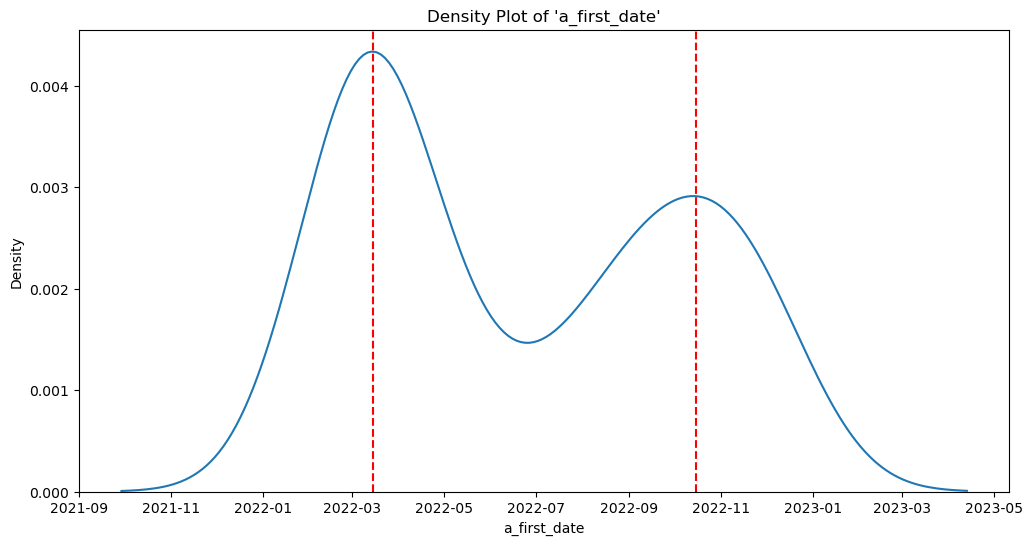

In [24]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data = DID_cls_Treatment['a_first_date'])
plt.xlabel('a_first_date')
plt.ylabel('Density')

plt.axvline(x = datetime.strptime('2022-03-15', '%Y-%m-%d'),
            color = 'red', linestyle = '--')
plt.axvline(x = datetime.strptime('2022-10-15', '%Y-%m-%d'),
            color = 'red', linestyle = '--')
plt.title("Density Plot of 'a_first_date'")
plt.show()

**Note**  
We can choose 2022-03-15 and 2022-10-15 as our 'breakpoint'.

In [25]:
# Select products with a_first_date around 2022-03 (excluding products with a_last_date before 2023-01)
DID_cls_Treatment_1 = DID_cls_Treatment[(DID_cls_Treatment['a_first_date'] <= '2022-05-01') &
                                        (DID_cls_Treatment['a_last_date'] >= '2023-01-01')]

# Get the ASINs of the selected products (48 products)
DID_cls_Treatment_Asin_1 = DID_cls_Treatment_1.index

# Check the category of the selected products
temp = Ads[Ads['asin'].isin(DID_cls_Treatment_Asin_1)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Treatment_Asin_1_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')

# Keep only the products in the "Health & HouseHold" category
DID_cls_Treatment_Asin_1 = DID_cls_Treatment_Asin_1_Category[
    DID_cls_Treatment_Asin_1_Category['category'] == 'Health & HouseHold'].asin

In [26]:
# Select products with a_first_date around 2022-10 (excluding products with a_last_date before 2023-01)
DID_cls_Treatment_2 = DID_cls_Treatment[(DID_cls_Treatment['a_first_date'] <= '2022-12-01') &
                                        (DID_cls_Treatment['a_first_date'] >= '2022-09-01') &
                                        (DID_cls_Treatment['a_last_date'] >= '2023-01-01')]

# Get the ASINs of the selected products (29 products)
DID_cls_Treatment_Asin_2 = DID_cls_Treatment_2.index

# Check the category of the selected products
temp = Ads[Ads['asin'].isin(DID_cls_Treatment_Asin_2)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Treatment_Asin_2_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')

# Split the products into "Health & HouseHold" and "Home Product" categories（14 products）（13 products）
DID_cls_Treatment_Asin_2_HH = DID_cls_Treatment_Asin_2_Category[
    DID_cls_Treatment_Asin_2_Category['category'] == 'Health & HouseHold'].asin

DID_cls_Treatment_Asin_2_HP = DID_cls_Treatment_Asin_2_Category[
    DID_cls_Treatment_Asin_2_Category['category'] == 'Home Product'].asin

#### (ii) Control Group
---
- The control group is selected from the Ads dataset, due to the availability of additional information like keywords and brand in this dataset. The criteria to be part of the control group are:
    - **Minimal Advertisement Presence**: The product's actual advertisement days should constitute at most 5% of the total sales duration,   
      i.e., Actual Ads Days / Sales Days <= 5%.
    - **Specific Categories**: The products should belong to either the Health & Household or Home Product category.

In [27]:
DID_cls_Control = SandA_Info[(SandA_Info['a_actual'] / SandA_Info['s_delta'] <= 0.05) &
                             (SandA_Info['s_last_date'] >= '2022-12-31')]

# Get the ASINs of the selected control group products
DID_cls_Control_Asin = DID_cls_Control.index

# Check the category of the control group products
temp = Ads[Ads['asin'].isin(DID_cls_Control_Asin)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Control_Asin_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')

# Split the control group products into "Health & HouseHold" category(210 products)
DID_cls_Control_Asin_HH = DID_cls_Control_Asin_Category[
    DID_cls_Control_Asin_Category['category'] == 'Health & HouseHold'].asin

# Split the control group products into "Home Product" category(82 products)
DID_cls_Control_Asin_HP = DID_cls_Control_Asin_Category[
    DID_cls_Control_Asin_Category['category'] == 'Home Product'].asin

In [28]:
# Control Group for Treatment_1: Category = "Health & HouseHold"
# Select control group products that have sales records before February 1, 2022
DID_cls_Control_1 = DID_cls_Control[DID_cls_Control['s_first_date'] <= '2022-02-01']
DID_cls_Control_1 = DID_cls_Control_1[DID_cls_Control_1.index.isin(DID_cls_Control_Asin_HH)]

# Get the ASINs of the selected control group products for Treatment_1
DID_cls_Control_Asin_1 = DID_cls_Control_1.index

In [29]:
# Control Group for Treatment_2: Category = "Health & HouseHold"
# Select control group products that have sales records before September 1, 2022
DID_cls_Control_2 = DID_cls_Control[DID_cls_Control['s_first_date'] <= '2022-09-01']
DID_cls_Control_2_HH = DID_cls_Control_2[DID_cls_Control_2.index.isin(DID_cls_Control_Asin_HH)]

# Get the ASINs of the selected control group products for Treatment_2 in the "Health & HouseHold" category
DID_cls_Control_Asin_2_HH = DID_cls_Control_2_HH.index

# Control Group for Treatment_2: Category = "Home Product"
# Select control group products that have sales records before September 1, 2022
DID_cls_Control_2_HP = DID_cls_Control_2[DID_cls_Control_2.index.isin(DID_cls_Control_Asin_HP)]

# Get the ASINs of the selected control group products for Treatment_2 in the "Home Product" category
DID_cls_Control_Asin_2_HP = DID_cls_Control_2_HP.index

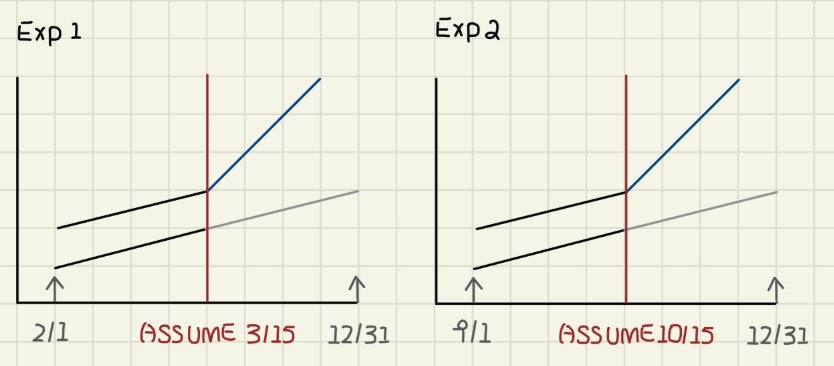

#### (iii) Data Aggregation

In [30]:
# Parallel Trend
# This function generates a parallel trend plot, a visual check for the key assumption of the Difference-in-Differences (DiD) design. 
# It divides the data into treatment and control groups, as well as before and after treatment periods, and plots the trend lines.
def plot_parallel_trend(data):
    
    cls_treatment = data[data['treat'] == 1]
    cls_control = data[data['treat'] == 0]
    cls_treatment_before = cls_treatment[cls_treatment['after'] == 0]
    cls_treatment_after = cls_treatment[cls_treatment['after'] == 1]
    cls_control_before = cls_control[cls_control['after'] == 0]
    cls_control_after = cls_control[cls_control['after'] == 1]

    cls_treatment_avg = cls_treatment.groupby('date')['units_total'].mean()
    cls_control_avg = cls_control.groupby('date')['units_total'].mean()
    cls_treatment_before_avg = cls_treatment_before.groupby('date')['units_total'].mean()
    cls_treatment_after_avg = cls_treatment_after.groupby('date')['units_total'].mean()
    cls_control_before_avg = cls_control_before.groupby('date')['units_total'].mean()
    cls_control_after_avg = cls_control_after.groupby('date')['units_total'].mean()

    treatment_before_x = np.arange(len(cls_treatment_before_avg))
    treatment_before_coefficients = np.polyfit(treatment_before_x, cls_treatment_before_avg, 1)
    treatment_before_poly = np.poly1d(treatment_before_coefficients)

    treatment_after_x = np.arange(len(cls_treatment_before_avg), len(cls_treatment_after_avg) + len(cls_treatment_before_avg))
    treatment_after_coefficients = np.polyfit(treatment_after_x, cls_treatment_after_avg, 1)
    treatment_after_poly = np.poly1d(treatment_after_coefficients)

    control_before_x = np.arange(len(cls_control_before_avg))
    control_before_coefficients = np.polyfit(control_before_x, cls_control_before_avg, 1)
    control_before_poly = np.poly1d(control_before_coefficients)

    control_after_x = np.arange(len(cls_control_before_avg), len(cls_control_after_avg) + len(cls_control_before_avg))
    control_after_coefficients = np.polyfit(control_after_x, cls_control_after_avg, 1)
    control_after_poly = np.poly1d(control_after_coefficients)

    treatment_x = np.arange(len(cls_treatment_avg))
    treatment_coefficients = np.polyfit(treatment_x, cls_treatment_avg, 1)
    treatment_poly = np.poly1d(treatment_coefficients)

    control_x = np.arange(len(cls_control_avg))
    control_coefficients = np.polyfit(control_x, cls_control_avg, 1)
    control_poly = np.poly1d(control_coefficients)

    plt.figure(figsize=(15, 3))
    plt.plot(treatment_before_x, treatment_before_poly(treatment_before_x) * 0.4, color='green', linestyle='--')
    plt.plot(treatment_after_x, treatment_after_poly(treatment_after_x) * 0.4, color='green', linestyle='--')
    plt.plot(control_before_x, control_before_poly(control_before_x), color='blue', linestyle='--')
    plt.plot(control_after_x, control_after_poly(control_after_x), color='blue', linestyle='--')
    plt.plot(treatment_x, treatment_poly(treatment_x) * 0.4, color='green', label='treatment')
    plt.plot(control_x, control_poly(control_x), color='blue', label='control')
    plt.legend(loc='upper left')
    plt.title('Parallel Trend')
    plt.xlabel('Time')
    plt.show()

##### a. Experimental 1
- Data Range: 2022-02-01 - 2022-12-31
- BreakPoint: 2022-03-15
- Catgory: Health & HouseHold

In [31]:
DID_cls_df_1 = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_1) | 
                     Sales['asin'].isin(DID_cls_Control_Asin_1)][['asin', 'date', 'units_total']]
DID_cls_df_1 = DID_cls_df_1[(DID_cls_df_1['date'] >= '2022-02-01') & (DID_cls_df_1['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_1['treat'] = DID_cls_df_1['asin'].isin(DID_cls_Treatment_Asin_1).astype(int)
# Flag if after 2022-03-15
DID_cls_df_1['after'] = (DID_cls_df_1['date'] >= '2022-03-15').astype(int)

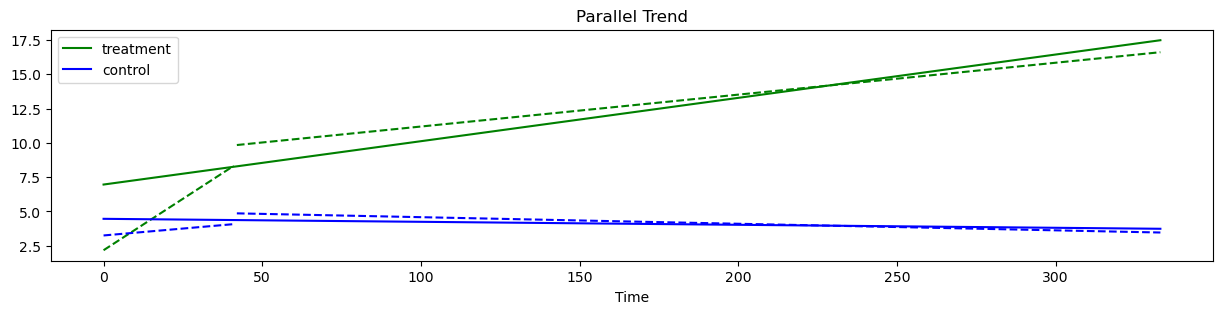

In [32]:
# Parallel Trend
plot_parallel_trend(DID_cls_df_1)

##### b. Experimental 2
- Data Range: 2022-09-01 - 2022-12-31
- BreakPoint: 2022-10-15
- Category: Health & HouseHold

In [33]:
DID_cls_df_2_HH = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_2_HH) | 
                  Sales['asin'].isin(DID_cls_Control_Asin_2_HH)][['asin', 'date', 'units_total']]
DID_cls_df_2_HH = DID_cls_df_2_HH[(DID_cls_df_2_HH['date'] >= '2022-09-01') & (DID_cls_df_2_HH['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_2_HH['treat'] = DID_cls_df_2_HH['asin'].isin(DID_cls_Treatment_Asin_2_HH).astype(int)
# Flag if after 2022-10-15
DID_cls_df_2_HH['after'] = (DID_cls_df_2_HH['date'] >= '2022-10-15').astype(int)

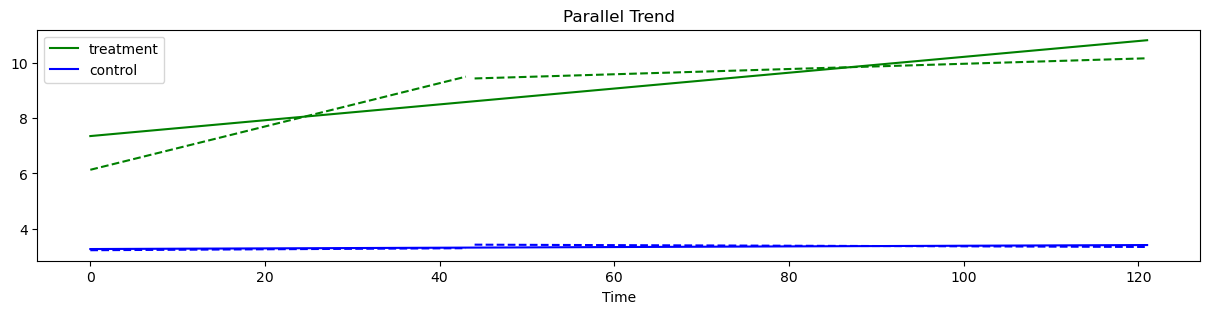

In [34]:
plot_parallel_trend(DID_cls_df_2_HH)

##### c. Experimental 3
- Data Range: 2022-09-01 - 2022-12-31
- BreakPoint: 2022-10-15
- Category: Home Product

In [35]:
DID_cls_df_2_HP = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_2_HP) | 
                  Sales['asin'].isin(DID_cls_Control_Asin_2_HP)][['asin', 'date', 'units_total']]
DID_cls_df_2_HP = DID_cls_df_2_HP[(DID_cls_df_2_HP['date'] >= '2022-09-01') & (DID_cls_df_2_HP['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_2_HP['treat'] = DID_cls_df_2_HP['asin'].isin(DID_cls_Treatment_Asin_2_HP).astype(int)
# Flag if after 2022-10-15
DID_cls_df_2_HP['after'] = (DID_cls_df_2_HP['date'] >= '2022-10-15').astype(int)

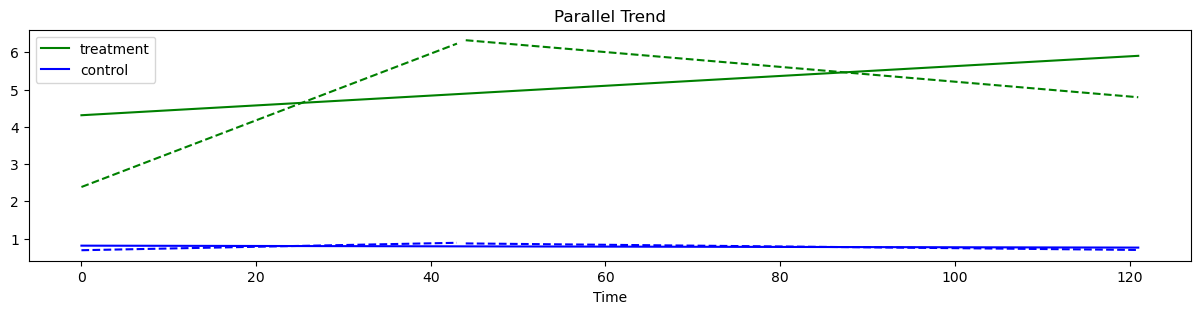

In [36]:
plot_parallel_trend(DID_cls_df_2_HP)

**Note**  
The experimental analyses provided a preliminary assessment of the parallel trend assumption. However, it's important to note that the filtering and processing methods used may be overly simplistic and cannot be considered as a definitive conclusion. The presence of confounding factors and other variables not considered in this analysis may introduce uncertainty. Further analysis and evaluation are required to draw more accurate conclusions.

### 2.2 Model

In [37]:
# EXP1: 19.4662***
mod_did_cls_1 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_1).fit()
mod_did_cls_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     947.9
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        00:04:26   Log-Likelihood:            -3.3230e+05
No. Observations:               69472   AIC:                         6.650e+05
Df Residuals:                   69262   BIC:                         6.669e+05
Df Model:                         209                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.9674      1.618      3.688      0.000       2.796       9.139
C(asin)[T.B00014FSRK]    -3.7161      2.241     -1.658      0.097      -8.108       0.676
C(asin)[T.B00014HNZK]    -4.7854      2.241     -2.136      0.033      -9.177      -0.393
C(asin)[T.B00028N3IG]    -5.9744      2.241     -2.666      0.008     -10.366      -1.583
C(asin)[T.B00028N408]    -4.5756      2.241     -2.042      0.041      -8.967      -0.184
C(asin)[T.B00028N4QC]    -5.1740      2.241     -2.309      0.021      -9.566      -0.782
C(asin)[T.B00028N4R6]    -5.6886      2.241     -2.539      0.011     -10.080      -1.297
C(asin)[T.B00028N69C]    -6.0253      2.241     -2.689      0.007     -10.417      -1.633
C(asin)[T.B00028N7F0]    -5.3482      2.241     -2.387      0.017      -9.740      -0.956
C(asin)[T.B00028NA2A]    -5.7611      2.241     -2.571      0.010     -10.153      -1.369
C(asin)[T.B00028OMMC]    -4.0529      2.241     -1.809      0.070      -8.445       0.339
C(asin)[T.B00028OMPO]    -4.3088      2.241     -1.923      0.054      -8.701       0.083
C(asin)[T.B00028OMWW]     0.6345      2.241      0.283      0.777      -3.757       5.026
C(asin)[T.B00028ONPI]     2.7801      2.241      1.241      0.215      -1.612       7.172
C(asin)[T.B0006SVYAQ]    -6.0933      2.241     -2.719      0.007     -10.485      -1.701
C(asin)[T.B0006SW0YU]    -5.7796      2.241     -2.579      0.010     -10.171      -1.388
C(asin)[T.B0006SW16W]     0.9094      2.241      0.406      0.685      -3.482       5.301
C(asin)[T.B000GBPMFG]    -5.2040      2.241     -2.322      0.020      -9.596      -0.812
C(asin)[T.B000KYKOGG]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000KYMBSK]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000KYSDEG]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000L981X8]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000L98250]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000L9CBAW]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000L9CXGO]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000LNOSQI]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000LNQ36G]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000LNRHXY]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000LNRHYS]  1.253e+11   3.94e+11      0.318      0.750   -6.46e+11    8.97e+11
C(asin)[T.B000MCXT8G]    -5.5160      2.241     -2.462      0.014      -9.908      -1.124
C(asin)[T.B000MD3IV8]    -5.3093      2.241     -2.369      0.018      -9.701      -0.917
C(asin)[T.B000MD3IW2]  

In [38]:
# EXP2: 4.8563***
mod_did_cls_2 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_2_HH).fit()
mod_did_cls_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     973.3
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        00:04:27   Log-Likelihood:                -74561.
No. Observations:               26840   AIC:                         1.496e+05
Df Residuals:                   26618   BIC:                         1.514e+05
Df Model:                         221                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.9699      0.355     11.170      0.000       3.273       4.667
C(asin)[T.B00014FSRK]    -1.6556      0.500     -3.308      0.001      -2.636      -0.675
C(asin)[T.B00014HNZK]    -0.7293      0.500     -1.457      0.145      -1.710       0.252
C(asin)[T.B00028N3IG]    -3.4917      0.500     -6.977      0.000      -4.473      -2.511
C(asin)[T.B00028N408]    -1.6719      0.500     -3.341      0.001      -2.653      -0.691
C(asin)[T.B00028N4QC]    -2.6228      0.500     -5.241      0.000      -3.604      -1.642
C(asin)[T.B00028N4R6]    -3.2129      0.500     -6.420      0.000      -4.194      -2.232
C(asin)[T.B00028N69C]    -3.6146      0.500     -7.223      0.000      -4.595      -2.634
C(asin)[T.B00028N7F0]    -2.8687      0.500     -5.732      0.000      -3.850      -1.888
C(asin)[T.B00028NA2A]    -3.4670      0.500     -6.928      0.000      -4.448      -2.486
C(asin)[T.B00028OMMC]    -1.6719      0.500     -3.341      0.001      -2.653      -0.691
C(asin)[T.B00028OMPO]    -0.7539      0.500     -1.506      0.132      -1.735       0.227
C(asin)[T.B00028OMWW]     2.2051      0.500      4.406      0.000       1.224       3.186
C(asin)[T.B00028ONPI]     5.9428      0.500     11.875      0.000       4.962       6.924
C(asin)[T.B0006SVYAQ]    -3.7129      0.500     -7.419      0.000      -4.694      -2.732
C(asin)[T.B0006SW0YU]    -3.1146      0.500     -6.223      0.000      -4.095      -2.134
C(asin)[T.B0006SW16W]     2.6641      0.500      5.323      0.000       1.683       3.645
C(asin)[T.B000GBPMFG]    -2.7867      0.500     -5.568      0.000      -3.768      -1.806
C(asin)[T.B000MCXT8G]    -3.2375      0.500     -6.469      0.000      -4.218      -2.257
C(asin)[T.B000MD3IV8]    -2.7949      0.500     -5.585      0.000      -3.776      -1.814
C(asin)[T.B000MD3IW2]    -3.7293      0.500     -7.452      0.000      -4.710      -2.748
C(asin)[T.B000MD3IWW]    -3.9752      0.500     -7.943      0.000      -4.956      -2.994
C(asin)[T.B000MD53J8]    -4.0080      0.500     -8.009      0.000      -4.989      -3.027
C(asin)[T.B000MD53K2]    -3.8523      0.500     -7.697      0.000      -4.833      -2.871
C(asin)[T.B000MDY7RC]    -3.8359      0.500     -7.665      0.000      -4.817      -2.855
C(asin)[T.B000MDY7SQ]    -3.6637      0.500     -7.321      0.000      -4.645      -2.683
C(asin)[T.B000ME1H4W]    -1.9998      0.500     -3.996      0.000      -2.981      -1.019
C(asin)[T.B000NCXZPW]    -4.0244      0.500     -8.041      0.000      -5.005      -3.043
C(asin)[T.B000TDODB0]    -2.9506      0.500     -5.896      0.000      -3.932      -1.970
C(asin)[T.B000TKKJR0]    -3.0326      0.500     -6.060      0.000      -4.014      -2.052
C(asin)[T.B000Z957ZO]    -3.0490      0.500     -6.092      0.000      -4.030      -2.068
C(asin)[T.B001100OTU]  

In [39]:
# EXP3: 3.1330*** 
mod_did_cls_3 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_2_HP).fit()
mod_did_cls_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1028.
Date:                Tue, 11 Jul 2023   Prob (F-statistic):               0.00
Time:                        00:04:28   Log-Likelihood:                -33634.
No. Observations:               10736   AIC:                         6.745e+04
Df Residuals:                   10646   BIC:                         6.810e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.4219      0.512      0.824      0.410      -0.581       1.425
C(asin)[T.B000AR2N44]    -0.1424      0.715     -0.199      0.842      -1.544       1.260
C(asin)[T.B000AR2OB6]     0.1068      0.714      0.150      0.881      -1.293       1.507
C(asin)[T.B000AR2OZ2]     1.1305      0.715      1.582      0.114      -0.270       2.531
C(asin)[T.B000BSB8G6]     4.4948      0.715      6.288      0.000       3.094       5.896
C(asin)[T.B000M9OLAO] -1.469e+12   1.57e+12     -0.934      0.350   -4.55e+12    1.61e+12
C(asin)[T.B000MNIB9C]     1.1073      0.715      1.549      0.122      -0.294       2.509
C(asin)[T.B000MS8F2A] -1.469e+12   1.57e+12     -0.934      0.350   -4.55e+12    1.61e+12
C(asin)[T.B000VZCPMA]    -0.3884      0.715     -0.543      0.587      -1.789       1.013
C(asin)[T.B0012H6H7A]     2.6773      0.715      3.746      0.000       1.276       4.078
C(asin)[T.B001AHSDQU]     0.9028      0.715      1.263      0.207      -0.499       2.304
C(asin)[T.B001UGGDWW]     1.1805      0.715      1.652      0.099      -0.220       2.581
C(asin)[T.B002KEV4SQ]    -0.3368      0.715     -0.471      0.637      -1.738       1.064
C(asin)[T.B0032OU5JM] -1.469e+12   1.57e+12     -0.934      0.350   -4.55e+12    1.61e+12
C(asin)[T.B0035O37DU] -1.469e+12   1.57e+12     -0.934      0.350   -4.55e+12    1.61e+12
C(asin)[T.B0038PFCOI]     2.0196      0.714      2.827      0.005       0.619       3.420
C(asin)[T.B0038WTTVS]     9.0440      0.714     12.660      0.000       7.644      10.444
C(asin)[T.B003KWSN04]    -0.4062      0.714     -0.569      0.570      -1.806       0.994
C(asin)[T.B003SXWSXI]     1.6921      0.714      2.369      0.018       0.292       3.092
C(asin)[T.B004IK82XU]    -0.4138      0.714     -0.579      0.562      -1.814       0.986
C(asin)[T.B005XNXG3M]    -0.4130      0.714     -0.578      0.563      -1.813       0.987
C(asin)[T.B005XNXMQ8]     1.7405      0.714      2.436      0.015       0.340       3.141
C(asin)[T.B006L5QGJ2]     0.6475      0.714      0.907      0.364      -0.751       2.046
C(asin)[T.B007N77TNO]    -0.2063      0.714     -0.289      0.773      -1.606       1.194
C(asin)[T.B00BJGOF28] -1.469e+12   1.57e+12     -0.934      0.350   -4.55e+12    1.61e+12
C(asin)[T.B00E5N0AKI]    -0.0684      0.714     -0.096      0.924      -1.469       1.332
C(asin)[T.B00E9B05TM]     1.5183      0.714      2.125      0.034       0.118       2.919
C(asin)[T.B00JALSA7A]     1.3290      0.714      1.860      0.063      -0.072       2.730
C(asin)[T.B00JALSFQ6]     1.8638      0.714      2.609      0.009       0.463       3.264
C(asin)[T.B00K1XVJJM]    -0.3557      0.714     -0.498      0.619      -1.756       1.045
C(asin)[T.B00K5DB5G0]    -0.3897      0.714     -0.546      0.585      -1.790       1.011
C(asin)[T.B00K5DBH3G]  

## 3 Staggered DID
---
- In this section, we implement a Staggered DiD design with the following conditions:

    - **Selection of Products**: We consider only those products that have sales records spanning from 2022-01-02 to 2022-12-31, a total of 364 days.

    - **Advertisement Indicator**: For each product and each day within the above period, we assign an 'ads' indicator. 'ads' is set to 1 if the product had advertisements on that day, and 0 otherwise.

- This Staggered DiD design allows us to assess the impact of advertisements on sales, accounting for products that started advertising at different points in time.

### 3.1 Preparation

In [40]:
DID_stg_Asin = Sales_SandE[(Sales_SandE.index.isin(Ads_Asin)) & 
                           (Sales_SandE.s_first_date == '2022-01-02') &
                           (Sales_SandE.s_delta >= 364)].index

DID_stg_df = Ads_Agg[(Ads_Agg.asin.isin(DID_stg_Asin)) & 
                     (Ads_Agg.date <= '2022-12-31')][['asin', 'date', 'units_total','total_rev', 'ads']]
DID_stg_df = DID_stg_df.set_index(['asin', 'date'])

### 3.2 Staggered DID Model

In [41]:
PanelOLS.from_formula('units_total ~ ads + EntityEffects', data = DID_stg_df).fit()

Dep. Variable:,units_total,R-squared:,0.0102
Estimator:,PanelOLS,R-squared (Between):,0.0419
No. Observations:,583128,R-squared (Within):,0.0102
Date:,"Tue, Jul 11 2023",R-squared (Overall):,0.0385
Time:,00:04:29,Log-likelihood,-2.522e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5965.3
Entities:,1602,P-value,0.0000
Avg Obs:,364.00,Distribution:,"F(1,581525)"
Min Obs:,364.00,,
Max Obs:,364.00,F-statistic (robust):,5965.3


In [42]:
# Robust:
PanelOLS.from_formula('total_rev ~ ads + EntityEffects', data = DID_stg_df).fit()

Dep. Variable:,total_rev,R-squared:,0.0100
Estimator:,PanelOLS,R-squared (Between):,0.0514
No. Observations:,583128,R-squared (Within):,0.0100
Date:,"Tue, Jul 11 2023",R-squared (Overall):,0.0453
Time:,00:04:30,Log-likelihood,-4.627e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5881.6
Entities:,1602,P-value,0.0000
Avg Obs:,364.00,Distribution:,"F(1,581525)"
Min Obs:,364.00,,
Max Obs:,364.00,F-statistic (robust):,5881.6


# Part III Matching + DID Model

## 1 Information Collection
---
- We have gathered a wealth of information about each product, primarily through web scraping. This includes:

    1. **Category**: The product category that the item falls under.

    2. **Rating**: The average customer rating of the product.

    3. **Number of Ratings**: The total number of customer ratings the product has received.

    4. **Price**: We calculate this as the ratio of total revenue to sales days for each product.

    5. **Average Units Sold Without Advertising**: The average quantity of the product sold on days without advertising.

- Further, we've enhanced the category data by splitting it into:

    - **First Category**: The top-most category for the product.

    - **Second Category**: The sub-category under the top-most category for the product.

    - **Last Category**: The most specific category for the product.

- Finally, we've also created:

    - **Month Dummy Variables**: These are indicator variables for each month, indicating whether the product was sold during that month or not.
- This collection of information provides a rich data set for us to analyze the effects of advertising on product sales, while controlling for various product characteristics.

## 2 Preparation

In [43]:
# Month Dummy Variables
'''Sales_2022 = Sales[(Sales['date'] >= '2022-01-01') & (Sales['date'] <= '2022-12-31')]
monthly_sales = Sales_2022.groupby(['asin', Sales_2022['date'].dt.month])['units_total'].sum().reset_index()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sales_pivot = monthly_sales.pivot(index = 'asin', columns = 'date', values = 'units_total').fillna(0)
monthly_sales_pivot.columns = months
Monthly_Sales_Dummy = monthly_sales_pivot.applymap(lambda x: 1 if x >= 1 else 0)'''

"Sales_2022 = Sales[(Sales['date'] >= '2022-01-01') & (Sales['date'] <= '2022-12-31')]\nmonthly_sales = Sales_2022.groupby(['asin', Sales_2022['date'].dt.month])['units_total'].sum().reset_index()\nmonths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']\nmonthly_sales_pivot = monthly_sales.pivot(index = 'asin', columns = 'date', values = 'units_total').fillna(0)\nmonthly_sales_pivot.columns = months\nMonthly_Sales_Dummy = monthly_sales_pivot.applymap(lambda x: 1 if x >= 1 else 0)"

### 2.1 Treatment Group
- To ensure the quality and relevance of our treatment group, we perform the following exclusions:

    - Unavailable Websites: We drop products for which the associated websites are not available.

    - Continuous Advertising: We exclude products that were continuously advertised throughout the sales period. These cases do not provide suitable control periods for us to contrast with the advertising periods.

    - Zero Sales Revenue: Products that have zero sales revenue are removed from the treatment group. These products do not provide useful information for assessing the impact of advertising on sales.

In [44]:
Treatment_Group = pd.read_csv('Treatment_Group.csv').set_index('asin')
# Drop rows with missing values in 'first_category', 'average_units_noads', or 'Price'
Drop1 = Treatment_Group[Treatment_Group['first_category'].isnull()]
Drop2 = Treatment_Group[Treatment_Group.average_units_noads.isnull()]
Drop3 = Treatment_Group[Treatment_Group.Price.isnull()]
Drop = Treatment_Group.index.isin(Drop1.index) | Treatment_Group.index.isin(Drop2.index) | Treatment_Group.index.isin(Drop3.index)
Treatment_Group = Treatment_Group[~Drop]
Treatment_Group.head()

,average_units_noads,Price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,rating,ratings,first_category,second_category,last_category,sales_days
asin,,,,,,,,,,,,,,,,,,,,
B00014TQ5A,64.420195,33.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.8,1654.0,Health & Household,"Vitamins, Minerals & Supplements",B-Complex,371
B08HPKVJXG,14.165746,36.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.8,340.0,Health & Household,"Vitamins, Minerals & Supplements",Vitamin C,371
B09CG7C8D4,0.111111,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,4.5,100.0,Home & Kitchen,Kitchen & Dining,Skillets,141
B09PC3TTK3,0.173077,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.9,12.0,"Clothing, Shoes & Jewelry",Women,Socks,107
B001683A34,2.236287,62.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.6,50.0,Health & Household,"Vitamins, Minerals & Supplements",Blended Vitamin & Mineral Supplements,371


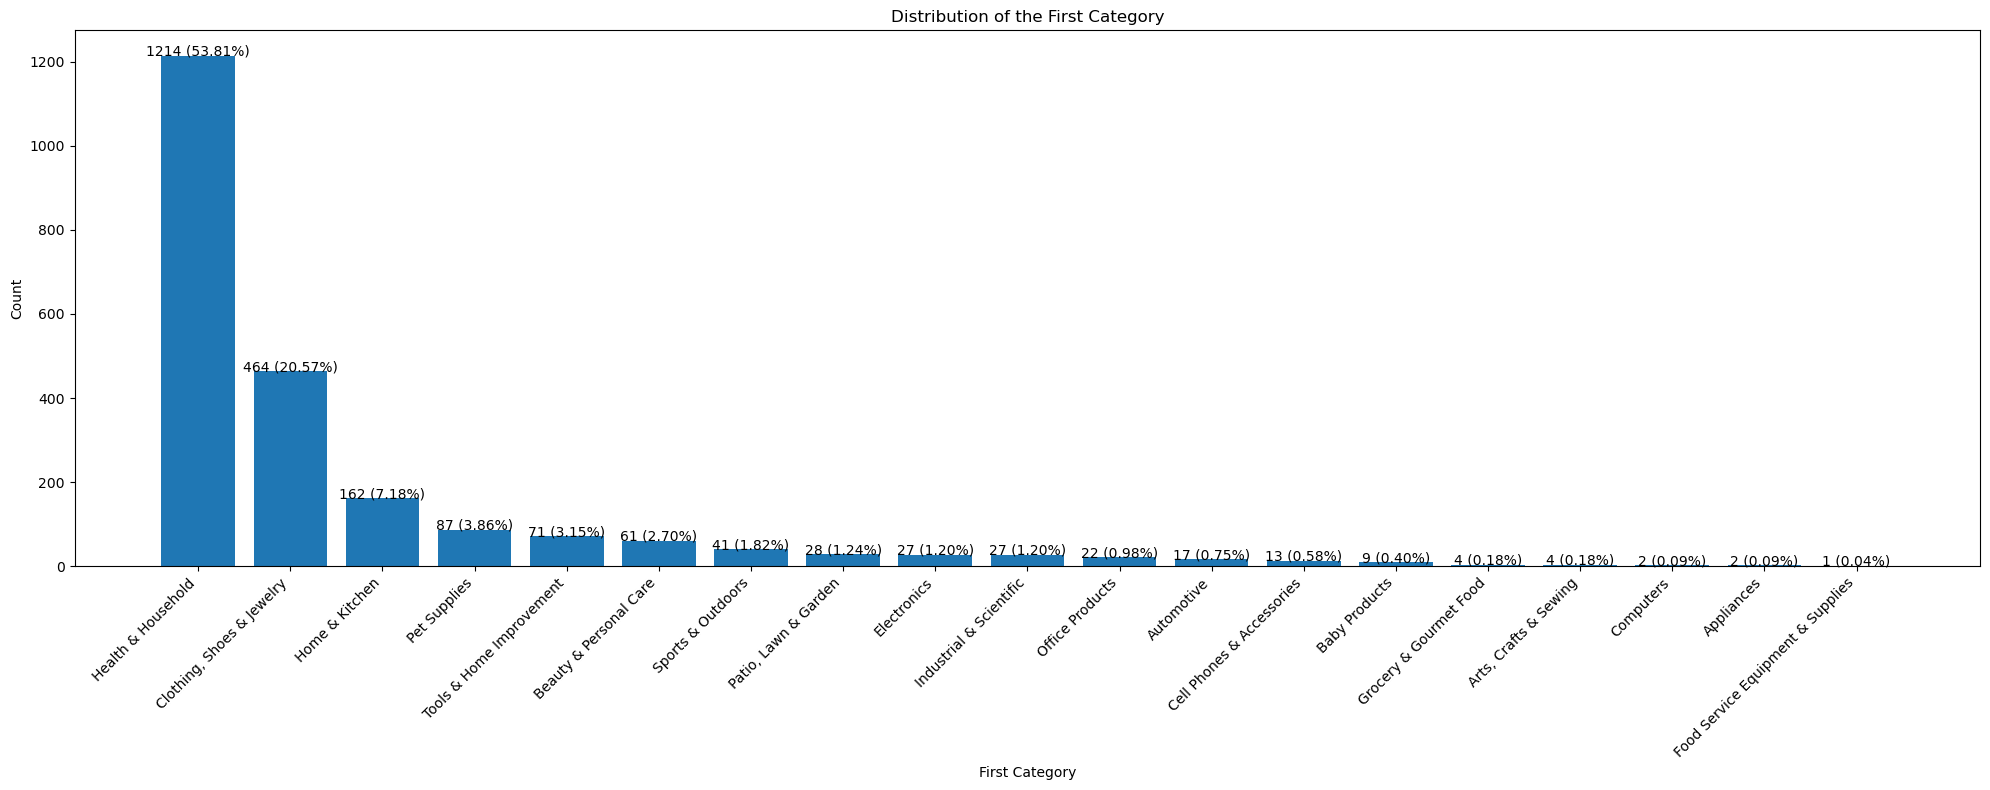

In [45]:
Category_Counts_Treatment = Treatment_Group['first_category'].value_counts()
plt.figure(figsize=(20, 8))
plt.bar(Category_Counts_Treatment.index, Category_Counts_Treatment)
plt.title('Distribution of the First Category')
plt.xlabel('First Category')
plt.ylabel('Count')
plt.xticks(rotation = 45, ha = 'right')
for i, count in enumerate(Category_Counts_Treatment):
    plt.text(i, count, f"{count} ({count/sum(Category_Counts_Treatment)*100:.2f}%)", ha = 'center')
plt.tight_layout()
plt.show()

**Note**
- Upon examining the product distribution, we find that:

    - The category ``Health & Household`` alone accounts for half of the products in our dataset.

    - If we consider the cumulative percentage of products in the ``Health & Household``, ``Clothing, Shoes & Jewelry``, and ``Home & Kitchen`` categories, they collectively represent over 80% of our dataset.

### 2.2 Control Group Refinement

- To ensure our control group is comparable to our treatment group, we perform the following steps:

    - Category Matching: We select products that share the same primary category (``first_category``) as those in the treatment group. This ensures that our control group is similar to our treatment group in terms of the product category, which is a critical factor that could influence sales performance.

    - Website Availability: We remove products for which the associated websites are not available. This ensures that all products in our control group have the same level of online presence as those in our treatment group.

In [46]:
Control_Group = pd.read_csv('Control_Group.csv').set_index('asin')
# Select unique values of 'first_category' from Treatment_Group
First_Cat_seleced = Treatment_Group.first_category.unique()
# Filter Control_Group to include only rows with 'first_category' values present in Treatment_Group
Control_Group = Control_Group[Control_Group['first_category'].isin(First_Cat_seleced)]
# Drop rows with missing values in 'first_category' from Control_Group
Control_Group = Control_Group.dropna(subset = ['first_category'])
Control_Group.head()

,average_units_noads,Price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,rating,ratings,first_category,second_category,last_category,sales_days
asin,,,,,,,,,,,,,,,,,,,,
B081B8YXLF,0.091644,70.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.4,18.0,"Clothing, Shoes & Jewelry",Men,Hiking Shoes,371
B09DNCYHBL,0.053571,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.3,69.0,Home & Kitchen,Home Décor Products,Panels,56
B01KMASISI,0.002695,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.4,156.0,"Clothing, Shoes & Jewelry",Women,Bangle,371
B07Q5VK4S9,0.183288,47.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,Home & Kitchen,Bedding,Pillowcases,371
B0B2JRYC15,0.177419,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.6,139.0,"Clothing, Shoes & Jewelry",Boot Shop,Snow & Cold Weather,124


## 3 Matching

### 3.1 Preparation

In [47]:
num_features = ['average_units_noads', 'Price', 'rating', 'ratings']
dummy = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### (i) Evaluation Matching Quality
- Compare whether the distribution of matched samples converge on each feature (num_features)

In [48]:
def check_balance(matched_data, feature):
    """
    Check the balance of a specific feature between treatment and control groups after matching.

    Args:
        matched_data (DataFrame): DataFrame containing matched data with 'treatment_asin' and 'matched_asin' columns.
        feature (str): Name of the feature to compare.

    Returns:
        None
        Plot: Distribution Comparison
        t-test results

    """
    matched_data = matched_data.dropna()

    # Fill missing values in 'rating' and 'ratings' columns with 0
    Treatment_Group[['rating', 'ratings']] = Treatment_Group[['rating', 'ratings']].fillna(0)
    Control_Group[['rating', 'ratings']] = Control_Group[['rating', 'ratings']].fillna(0)

    # Select data for treatment and control groups based on matched data
    Treat = Treatment_Group.loc[matched_data['treatment_asin']]
    Control = Control_Group.loc[matched_data['matched_asin']]

    # Get the feature values for treatment and control groups
    Treat_features = Treat[feature]
    Control_features = Control[feature]

    # Plot the distribution of the feature after matching
    plt.figure(figsize = (15, 6))
    sns.histplot(Treat_features, color = 'orange', label = 'Treatment', kde = True)
    sns.histplot(Control_features, color = 'blue', label = 'Control', kde = True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of {} After Matching'.format(feature))

    # Perform t-test and print the results
    t_stat, p_value = ttest_ind(Treat_features, Control_features)
    print('T-Test Result - {}:'.format(feature))
    print('T-Statistic: {:.4f}'.format(float(t_stat)))
    print('P-Value: {:.4f}'.format(float(p_value)))

    # Check if the p-value is greater than 0.05 (significance level)
    if p_value > 0.05:
        print('The feature "{}" shows no significant difference after matching.'.format(feature))
    else:
        print('The feature "{}" shows a significant difference after matching.'.format(feature))
    print('')

#### (ii) Compare Matched Products' Sales Trend
- Plot two matched products' sales trend

In [49]:
def plot_total_units(asin_treat, asin_control_model, asin_control_manual):
    """
    Plot the sales trend of matched products.

    Args:
        asin_treat (str): ASIN of the treatment product.
        asin_control_model (str): ASIN of the control product (matched using a model).
        asin_control_manual (str): ASIN of the control product (matched manually).

    Returns:
        None
        Plot: sales trend

    """
    plt.figure(figsize = (30, 8))
    
    if asin_treat != 'pass':
        # Plot sales trend of the treatment product
        t = Ads_Agg
        t = t[t['asin'] == asin_treat]
        plt.plot(t.date, t.units_total, label='treat')
        
        # Mark the advertising time period
        ad_dates = t[t.ads == 1].date
        ad_dates = pd.DatetimeIndex(ad_dates)
        for i in range(len(ad_dates) - 1):
            plt.axvspan(ad_dates[i], ad_dates[i] + timedelta(days = 1), facecolor = 'gray', alpha=0.3)
        
    if asin_control_model != 'pass':
        # Plot sales trend of the control product (matched using a model)
        c_model = Sales[Sales['asin'] == asin_control_model].sort_values(by = 'date')
        plt.plot(c_model.date, c_model.units_total, label='control_model')

    if asin_control_manual != 'pass':
        # Plot sales trend of the control product (matched manually)
        c_manual = Sales[Sales['asin'] == asin_control_manual].sort_values(by = 'date')
        plt.plot(c_manual.date, c_manual.units_total, label = 'control_manual')

    plt.legend()
    plt.title('Total Units with Ad Annotation')
    plt.xlabel('Date')
    plt.ylabel('Total Units')
    plt.show()

#### (iii) Select Best Matched Product

In [50]:
def calculate_cointegration(asin_treat, data):
    """
    Calculate cointegration between a treatment product and its matched control products.

    Args:
        asin_treat (str): ASIN of the treatment product.
        data (DataFrame): Dataframe containing matched product information.

    Returns:
        str: ASIN of the best matched control product.
        tuple: Cointegration test result.

    """
    asin_control_model = data[data['treatment_asin'] == asin_treat]['matched_asin_model'].values[0]
    asin_control_manual = data[data['treatment_asin'] == asin_treat]['matched_asin_manual'].values[0]

    df_treat = Sales[Sales['asin'] == asin_treat].sort_values(by='date')[['date', 'units_total']]
    df_control_model = Sales[Sales['asin'] == asin_control_model].sort_values(by = 'date')[['date', 'units_total']]
    df_control_manual = Sales[Sales['asin'] == asin_control_manual].sort_values(by = 'date')[['date', 'units_total']]

    Compare_model = pd.merge(df_treat, df_control_model, on='date', suffixes=('', '_model'))
    Compare_model = pd.merge(Compare_model, Ads_Agg[Ads_Agg['asin'] == asin_treat][['date', 'ads']], on = 'date')
    result_model = sm.tsa.stattools.coint(Compare_model.loc[Compare_model['ads'] == 0, 'units_total'], Compare_model.loc[Compare_model['ads'] == 0, 'units_total_model'])

    Compare_manual = pd.merge(df_treat, df_control_manual, on='date', suffixes=('', '_manual'))
    Compare_manual = pd.merge(Compare_manual, Ads_Agg[Ads_Agg['asin'] == asin_treat][['date', 'ads']], on = 'date')
    result_manual = sm.tsa.stattools.coint(Compare_manual.loc[Compare_manual['ads'] == 0, 'units_total'], Compare_manual.loc[Compare_manual['ads'] == 0, 'units_total_manual'])

    if abs(result_model[0]) > abs(result_manual[0]):
        print('model matching is better')
        return asin_control_model, result_model
    elif abs(result_model[0]) < abs(result_manual[0]):
        print('manual matching is better')
        return asin_control_manual, result_manual
    else:
        print('same')
        return asin_control_model, result_model

#### (iv) Model

In [187]:
def DID_analyze(asin_treat, asin_control):
    """
    Perform Difference-in-Differences (DID) analysis between a treatment ASIN and a control ASIN.

    Args:
        asin_treat (str): ASIN of the treatment product.
        asin_control (str): ASIN of the control product.

    Returns:
        None

    """
    DID_treat = Ads_Agg[Ads_Agg.asin == asin_treat][['asin', 'date', 'units_total']]
    DID_Control = Sales[Sales['asin'] == asin_control].sort_values(by = 'date')[['asin', 'date', 'units_total']]

    DID_treat_subset = DID_treat[DID_treat['date'].isin(DID_Control['date'])]
    DID_Control_subset = DID_Control[DID_Control['date'].isin(DID_treat['date'])]

    DID = pd.concat([DID_treat_subset, DID_Control_subset], axis = 0)
    DID['treat'] = (DID['asin'] == asin_treat).astype(int)
    DID = pd.merge(DID, Ads_Agg[Ads_Agg.asin == asin_treat][['date', 'ads']], on = 'date')

    model = smf.ols(formula = 'units_total ~ treat * ads', data = DID).fit()

    print('\n', '########## Products Selected ##########')
    print('Treatment ASIN:', asin_treat)
    print('Control ASIN:', asin_control)
    print('\n', '########## Model Result ##########')
    print('Coefficients:')
    print(model.params[3])
    print('P-values:')
    p_val = model.pvalues[3]
    if p_val < 0.001:
        print(p_val, '=> ***')
    elif p_val < 0.01:
        print(p_val, '=> **')
    elif p_val < 0.05:
        print(p_val, '=> *')
    else:
        print(p_val)
    print('R-squared:')
    print(model.rsquared)
    
    
    # Plot sales trend
    plt.figure(figsize = (30, 6))
    plt.plot(DID_treat_subset['date'], DID_treat_subset['units_total'], label = 'Treatment ASIN')
    plt.plot(DID_Control_subset['date'], DID_Control_subset['units_total'], label = 'Control ASIN')
    plt.xlabel('Date')
    plt.ylabel('Total Units')
    plt.title('Sales Trend(Truncated and Zoom IN)')
    plt.legend()
    plt.show()

#### (v) Robustness Test

In [137]:
# Tests Combination
# Normality Test -> Levene's Test -> Paired Sample Test
# Not Normal / Not Equal Variance -> Wilcoxon Signed-Rank Test
def paired_sample_test(data, breakpoint):
    
    """
    Perform paired sample tests between two sets of data.

    Args:
        data (DataFrame): Data containing the paired samples.
        breakpoint (datetime): Breakpoint date to split the samples.

    Returns:
        tuple: p-value and test statistic of the chosen test.

    """
    
    data_before = data[data['date'] < breakpoint]['units_total']
    data_after = data[data['date'] >= breakpoint]['units_total']
    
    # Shapiro-Wilk Test
    _, p_value_shapiro1 = stats.shapiro(data_before)
    _, p_value_shapiro2 = stats.shapiro(data_after)

    if p_value_shapiro1 < 0.05 or p_value_shapiro2 < 0.05:
        print('The assumption of normality is violated.')
        # Wilcoxon Signed-Rank Test
        print('Wilcoxon Signed-Rank Test:')
        w_statistic, p_value_wilcox = stats.wilcoxon(data_before, data_after)
        if p_value_wilcox < 0.05:
            print('There is a statistically significant difference between the two paired samples.')
        else:
            print('No statistically significant difference is observed.')
        return p_value_wilcox, w_statistic
    else:
        # Levene's Test
        _, p_value_levene = stats.levene(data_before, data_after)
        if p_value_levene < 0.05:
            print('The assumption of homogeneity of variances is violated.')
            # Wilcoxon Signed-Rank Test
            print('Wilcoxon Signed-Rank Test:')
            w_statistic, p_value_wilcox = stats.wilcoxon(data_before, data_after)
            if p_value_wilcox < 0.05:
                print('There is a statistically significant difference between the two paired samples.')
            else:
                print('No statistically significant difference is observed.')
            return p_value_wilcox, w_statistic
        else:
            # Paired Sample t-test 
            print('Paired sample t-test:')
            t_statistic, p_value_ttest = stats.ttest_rel(data_before, data_after)
            if p_value_ttest < 0.05:
                print('There is a statistically significant difference between the two paired samples.')
            else:
                print('No statistically significant difference is observed.')
            return p_value_ttest, t_statistic

In [177]:
def robustness_test(asin_treat, asin_control, bp, bandwidth):
    """
    Calculate the robustness of the treatment effect by conducting paired sample tests between a treatment product and its best matched control product.

    Args:
        asin_treat (str): ASIN of the treatment product.
        best_matched (str): ASIN of the best matched control product.
        bp (str): Breakpoint date in the format 'YYYY-MM-DD'.
        bandwidth (int): Number of days before and after the breakpoint to include in the analysis.

    Returns:
        None

    """
    breakpoint = datetime.strptime(bp, '%Y-%m-%d')
    print('asin_treat:', asin_treat)
    print('asin_control:', asin_control)
    print('\n')
    
    # Extract sales data for treatment product within the specified time range
    sales_test_treat = Sales[(Sales['asin'] == asin_treat) & 
                            (Sales['date'] >= breakpoint - timedelta(bandwidth)) &
                            (Sales['date'] <= breakpoint + timedelta(bandwidth - 1))].sort_values(by='date')
    
    # Extract sales data for control product within the specified time range
    sales_test_control = Sales[(Sales['asin'] == asin_control) & 
                               (Sales['date'] >= breakpoint - timedelta(bandwidth)) &
                               (Sales['date'] <= breakpoint + timedelta(bandwidth - 1))].sort_values(by='date')
    
    # Perform paired sample tests for treatment and control products
    print(paired_sample_test(sales_test_treat, breakpoint))
    print('\n')
    print(paired_sample_test(sales_test_control, breakpoint))

### 3.2 Similarity: Manual Calculation

#### (i) Preprocessing

In [51]:
Similarity_Data = pd.concat([Treatment_Group, Control_Group])

# Identify treatment / control
Similarity_Data['treat'] = 0
Similarity_Data.loc[Treatment_Group.index, 'treat'] = 1

# Fill NA in rating and ratings
Similarity_Data[['rating', 'ratings']] = Similarity_Data[['rating', 'ratings']].fillna(0)

# Transformation
# BoxCox transformation
for feature in num_features:
    transformed_data, lambda_ = stats.boxcox(Similarity_Data[feature] + 1)
    Similarity_Data[feature] = transformed_data

# MinMax scaling
scaler = MinMaxScaler()
Similarity_Data[num_features] = scaler.fit_transform(Similarity_Data[num_features])

#### (ii) Treatment / Control Split

In [52]:
Treatment_Candidates = Similarity_Data[Similarity_Data.treat == 1]
Control_Candidates = Similarity_Data[Similarity_Data.treat == 0]

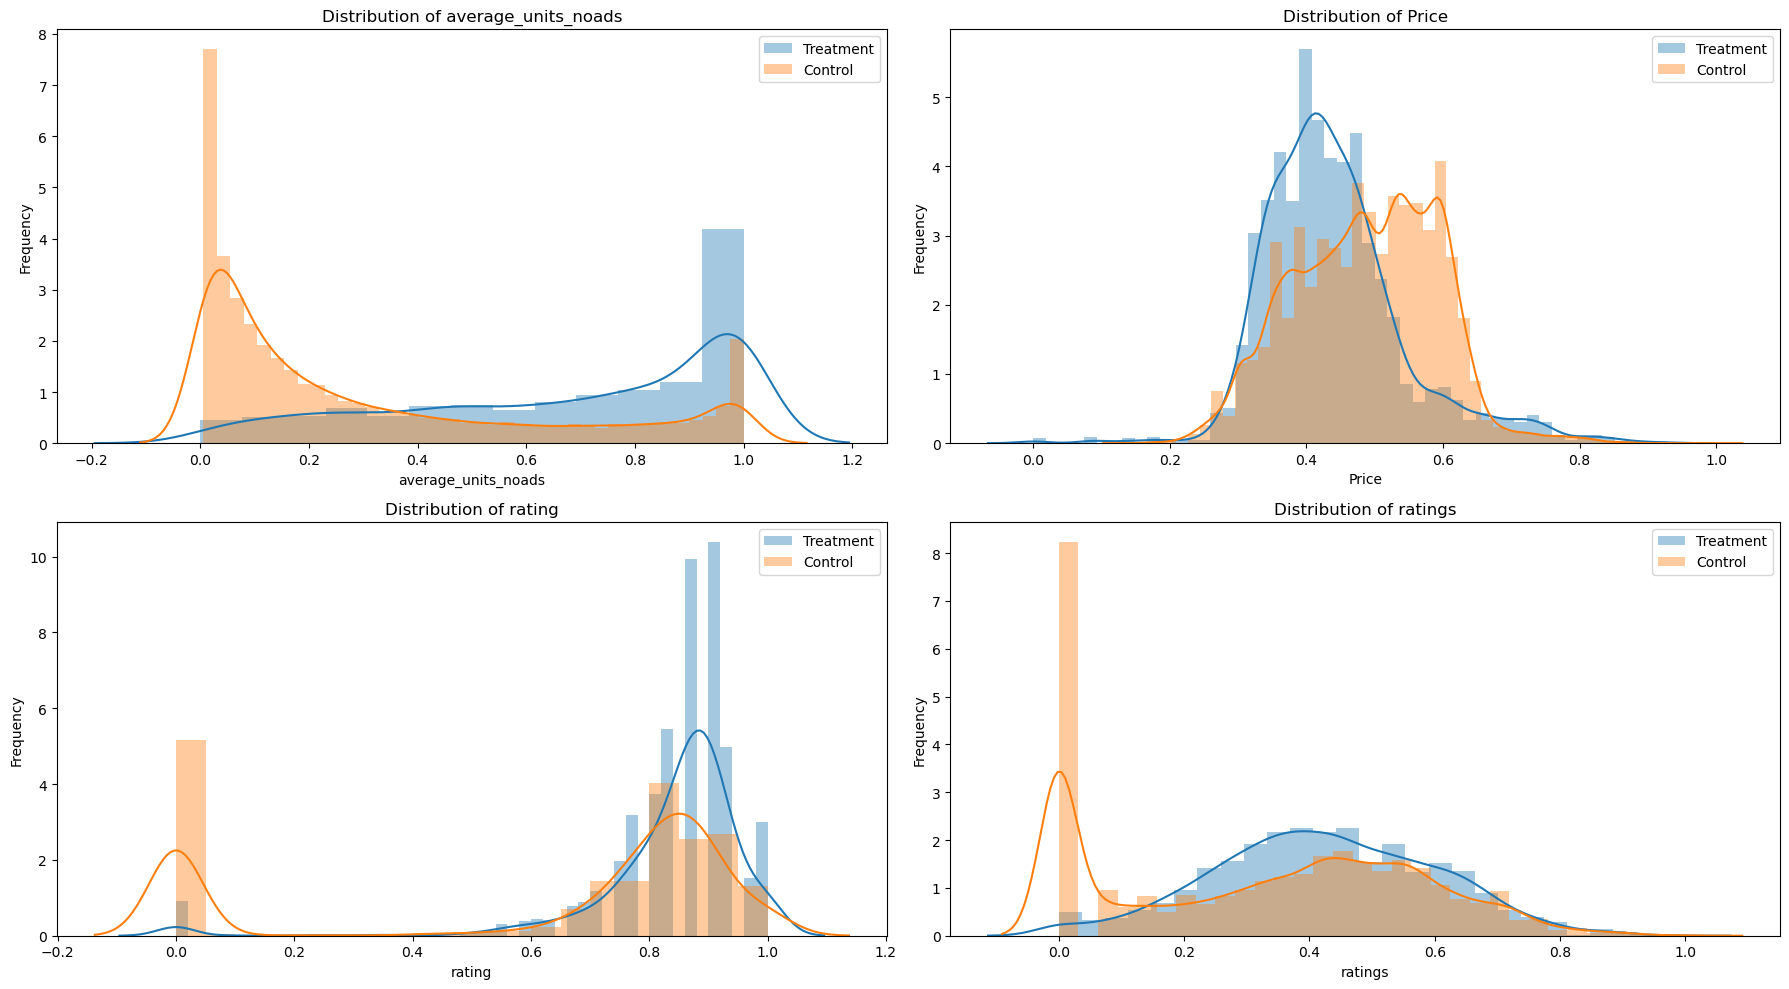

In [53]:
fig, axes = plt.subplots(2, 2, figsize = (18, 10))

for i, feature in enumerate(num_features):
    sns.distplot(Treatment_Candidates[feature], ax = axes[i//2, i%2], label = 'Treatment')
    sns.distplot(Control_Candidates[feature], ax = axes[i//2, i%2], label = 'Control')
    axes[i//2, i%2].set_xlabel(feature)
    axes[i//2, i%2].set_ylabel('Frequency')
    axes[i//2, i%2].set_title(f'Distribution of {feature}')
    axes[i//2, i%2].legend()
plt.tight_layout()    

#### (iii) Calculate Similarity and Match Data
- We calculate similarity scores based on the following features:
    - **Numerical Features**: We use Euclidean distance (from the ``numpy.linalg`` package) to calculate the similarity between numerical features.
    - **Dummy Variables**: For categorical features, we use Jaccard Similarity to calculate the similarity. The Jaccard index, also known as Intersection over Union, measures similarity between finite sample sets and is defined as the size of the intersection divided by the size of the union of the sample sets. 

In [54]:
# Jaccard Similarity
def jaccard_similarity(set1, set2):
    set1 = set(set1); set2 = set(set2) 
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [71]:
'''# around 5 min
before = time.time()

matched_data_similarity = []

# Iterate over treatment candidates
for _, t_row in Treatment_Candidates.iterrows():
    t_sample_num_features = t_row[num_features]
    t_sample_dum_features = t_row[dummy]
    t_sample_last_cat = t_row['last_category']
    t_sample_second_cat = t_row['second_category']
    t_sample_first_cat = t_row['first_category']
    
    min_similarity = np.inf
    best_match_index = None
    
    # Select control group candidates that have the same last_category as the t_sample
    control_last_cat = Control_Candidates[Control_Candidates['last_category'] == t_sample_last_cat]
    if not control_last_cat.empty:
        for _, c_row in control_last_cat.iterrows():
            c_sample_num_features = c_row[num_features]
            c_sample_dum_features = c_row[dummy]
            
            # Calculate similarity using Euclidean distance and Jaccard similarity
            similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
            similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
            similarity = 0.7 * similarity1 + 0.3 * (1 - similarity2)
            
            if similarity < min_similarity:
                min_similarity = similarity
                best_match_index = c_row.name
                if similarity == 0:
                    break
                    
    if best_match_index is None:
        # Select control group candidates that have the same second_category as the t_sample
        control_second_cat = Control_Candidates[Control_Candidates['second_category'] == t_sample_second_cat]
        if not control_second_cat.empty:
            for _, c_row in control_second_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7 * similarity1 + 0.3 * (1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    if best_match_index is None:
        # Select control group candidates that have the same first_category as the t_sample
        control_first_cat = Control_Candidates[Control_Candidates['first_category'] == t_sample_first_cat]
        if not control_first_cat.empty:
            for _, c_row in control_first_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7 * similarity1 + 0.3 * (1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    matched_data_similarity.append((t_row.name, best_match_index))
        
after = time.time()
time_used = after - before
print("Execution time:", time_used, "seconds")
Matched_Manual = pd.DataFrame(matched_data_similarity, columns = ['treatment_asin', 'matched_asin'])'''

'# around 5 min\nbefore = time.time()\n\nmatched_data_similarity = []\n\n# Iterate over treatment candidates\nfor _, t_row in Treatment_Candidates.iterrows():\n    t_sample_num_features = t_row[num_features]\n    t_sample_dum_features = t_row[dummy]\n    t_sample_last_cat = t_row[\'last_category\']\n    t_sample_second_cat = t_row[\'second_category\']\n    t_sample_first_cat = t_row[\'first_category\']\n    \n    min_similarity = np.inf\n    best_match_index = None\n    \n    # Select control group candidates that have the same last_category as the t_sample\n    control_last_cat = Control_Candidates[Control_Candidates[\'last_category\'] == t_sample_last_cat]\n    if not control_last_cat.empty:\n        for _, c_row in control_last_cat.iterrows():\n            c_sample_num_features = c_row[num_features]\n            c_sample_dum_features = c_row[dummy]\n            \n            # Calculate similarity using Euclidean distance and Jaccard similarity\n            similarity1 = np.linalg.n

In [56]:
Matched_Manual = pd.read_csv('Matched_Manual.csv', index_col = 0)
Matched_Manual

,treatment_asin,matched_asin
0,B00014TQ5A,B073YL2LTR
1,B08HPKVJXG,B009NYU6M6
2,B09CG7C8D4,B008M2T9GY
3,B09PC3TTK3,B09G8HYMQL
4,B001683A34,B00CS4KGJ6
...,...,...
2251,B07RZFGK87,B07GJKRK57
2252,B08B73FRCY,B01ISF0MLA
2253,B09PC4ZVBJ,B08SQ3NC6D
2254,B0BJ41DWKF,B0016A940U


In [57]:
# We don't have these categoris in the Control_Group
# Company; Food Service Equipment & Supplies
Matched_Manual[Matched_Manual.matched_asin.isnull()]

,treatment_asin,matched_asin
57,B07G4M5JM4,NaN
336,B0123X81UC,NaN
484,B005CJKF7C,NaN


### 3.3 Similarity: PSM Scroe + KNN

#### (i) Model: Logistic Regression

In [58]:
def PSM_log(X, y):
    # Grid search for selecting the best model parameters
    param_grid = {
        'C': np.logspace(-6, 3, num=10), 
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    
    # Using Logistic Regression to calculate propensity scores
    logreg = LogisticRegression()
    grid_search = GridSearchCV(logreg, param_grid, cv = 5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Get propensity scores
    propensity_scores = best_model.predict_proba(X)[:, 1]
    return propensity_scores, best_model

#### (ii) Calculate PSM Score and Match Data

In [59]:
def get_matched_data(first_category):
    """
    Perform propensity score matching and nearest neighbor matching to obtain matched treatment and control data.

    Args:
        first_category (str): First category used for matching.

    Returns:
        pd.DataFrame: Matched data containing treatment and control samples.
        object: Best model selected for propensity score calculation.
    """
    
    # Retrieve treatment and control data based on the first category
    temp1 = Treatment_Group[Treatment_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]
    temp2 = Control_Group[Control_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]
    PSM_Data = pd.concat([temp1, temp2])
    
    # Identify treatment / control
    PSM_Data['treat'] = 0
    PSM_Data.loc[temp1.index, 'treat'] = 1
    # Fill NA in rating and ratings
    PSM_Data[['rating', 'ratings']] = PSM_Data[['rating', 'ratings']].fillna(0)
    PSM_Data = PSM_Data.dropna()
    
    # Resample the data using SMOTE-NC
    X = PSM_Data.drop(['treat'], axis=1)
    y = PSM_Data['treat']
    numeric = X.select_dtypes(['float64', 'int64']).columns
    cat = X.select_dtypes(exclude=['float64', 'int64']).columns
    cat_indices = [X.columns.get_loc(col) for col in cat]
    smote = SMOTENC(categorical_features=cat_indices)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Transformation
    # Apply Box-Cox transformation to numerical features
    for feature in numeric:
        transformed_data, lambda_ = stats.boxcox(X_resampled[feature] + 1)
        X_resampled[feature] = transformed_data
    
    # Scale the numerical features using StandardScaler
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_resampled[numeric])
    X_scaled = pd.DataFrame(X_num_scaled, columns = numeric)
    
    # Get propensity scores using logistic regression
    propensity_scores, best_model = PSM_log(X_scaled, y_resampled)
    PSM_Data = PSM_Data.assign(score = list(propensity_scores)[:len(PSM_Data)])
    
    # Perform matching using KNN
    matcher = NearestNeighbors(n_neighbors = 1)
    control_candidates = PSM_Data[PSM_Data['treat'] == 0]
    treatment_candidates = PSM_Data[PSM_Data['treat'] == 1]
    
    matched_data = pd.DataFrame(columns=['treatment_asin', 'treatment_second_category', 'treatment_last_category', 'matched_asin', 'matched_second_category', 'matched_last_category'])
    
    for score_idx, score in enumerate(list(treatment_candidates.score)):
        treatment_sample = treatment_candidates.iloc[score_idx]
        
        # Select control group candidates based on last_category or second_category
        control_candidates_second = control_candidates[control_candidates['second_category'] == treatment_sample['second_category']]
        if len(control_candidates_second) > 0:
            control_candidates_last = control_candidates_second[control_candidates_second['last_category'] == treatment_sample['last_category']]
            if len(control_candidates_last) > 0:
                # Match treatment and control samples with the same last_category
                matcher.fit(np.array(control_candidates_last['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_last.iloc[nearest_idx[0][0]]
            else:
                # If no control samples with the same last_category, choose the closest one based on second_category
                matcher.fit(np.array(control_candidates_second['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_second.iloc[nearest_idx[0][0]]
        else:
            # If no control samples with the same second_category, choose the closest one based on first_category
            matcher.fit(np.array(control_candidates['score']).reshape(-1, 1))
            _, nearest_idx = matcher.kneighbors([[score]])
            nearest_control_data = control_candidates.iloc[nearest_idx[0][0]]
        
        # Add matched data to the result
        matched_data = pd.concat([matched_data, pd.DataFrame({
            'treatment_asin': treatment_sample.name,
            'treatment_second_category': treatment_sample['second_category'],
            'treatment_last_category': treatment_sample['last_category'],
            'matched_asin': nearest_control_data.name,
            'matched_second_category': nearest_control_data['second_category'],
            'matched_last_category': nearest_control_data['last_category']
        }, index = [0])], ignore_index = True)
    
    return matched_data, best_model

#### (iii) Pre-trained Model

##### Health & Household

In [72]:
'''category = 'Health & Household'
matched_data_HH_lr, best_model_HH_lr = get_matched_data(category)
best_model_HH_lr'''

LogisticRegression(C=0.0001, solver='liblinear')

In [74]:
'''with open('matched_data_HH_lr.pkl', 'wb') as f:
    pickle.dump(matched_data_HH_lr, f)
with open('best_model_HH_lr.pkl', 'wb') as f:
    pickle.dump(best_model_HH_lr, f)'''

T-Test Result - average_units_noads:
T-Statistic: 1.3598
P-Value: 0.1740
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 0.5658
P-Value: 0.5716
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 7.4516
P-Value: 0.0000
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 3.4558
P-Value: 0.0006
The feature "ratings" shows a significant difference after matching.



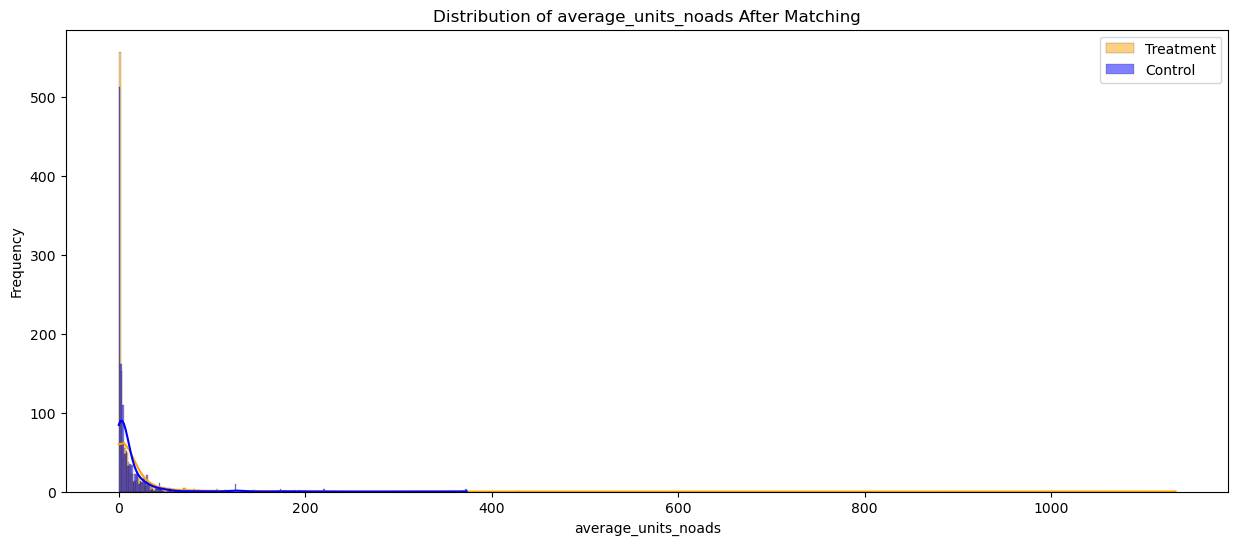

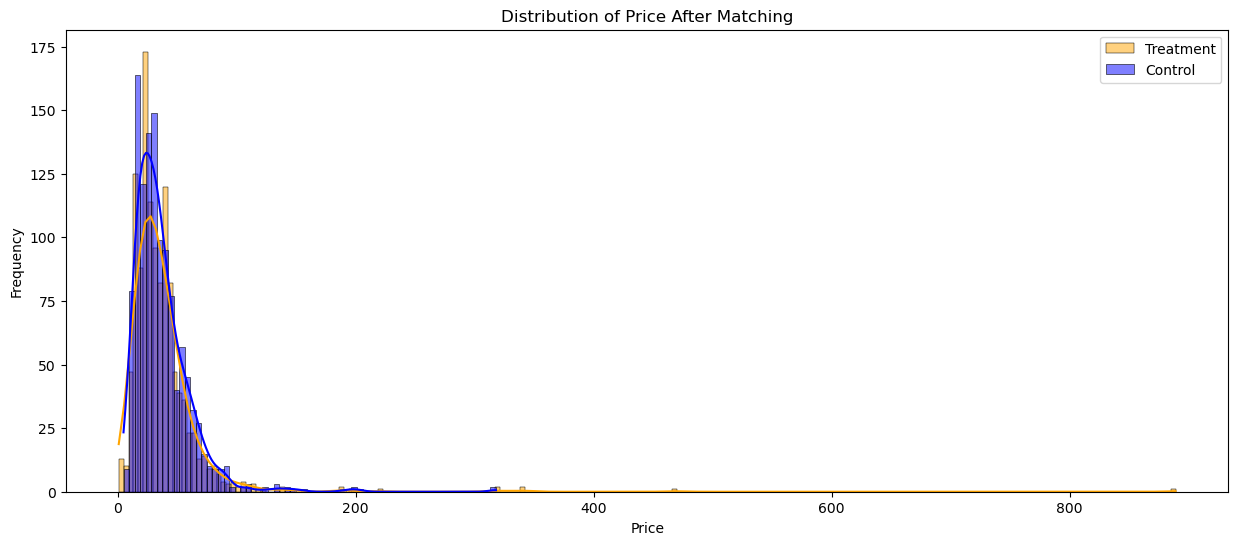

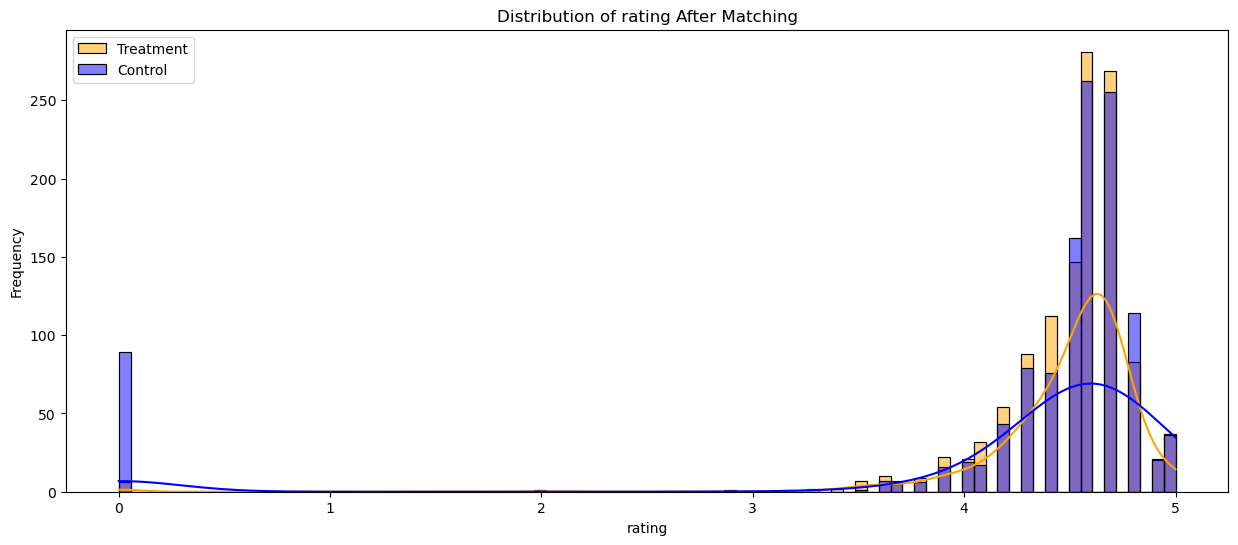

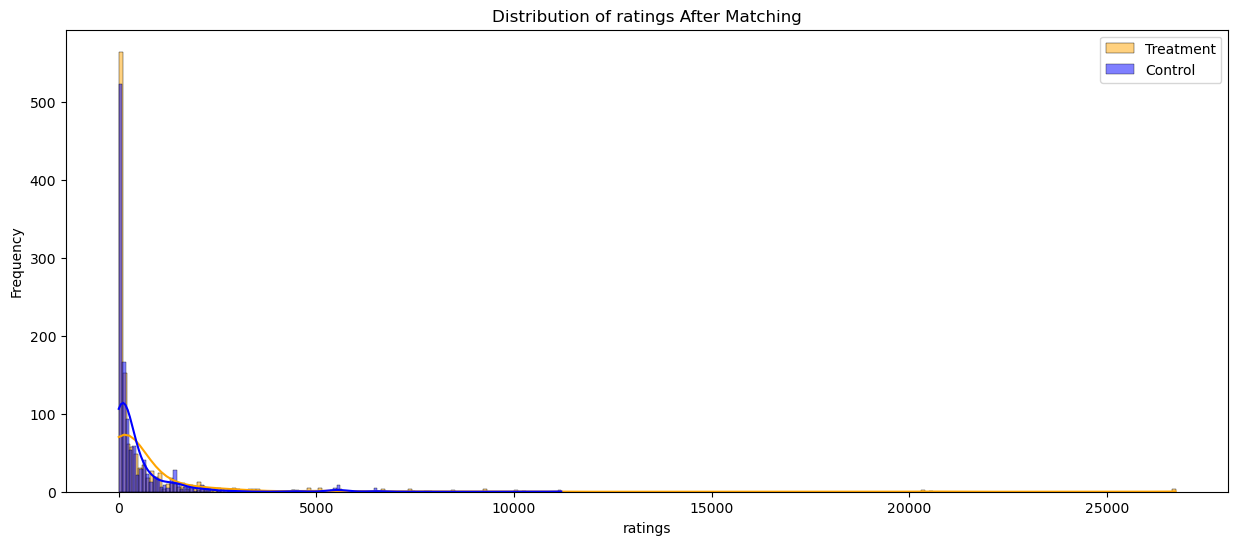

In [77]:
# Logistic
with open('matched_data_HH_lr.pkl', 'rb') as f:
    matched_data_HH_lr = pickle.load(f)
with open('best_model_HH_lr.pkl', 'rb') as f:
    best_model_HH_lr = pickle.load(f)
check_balance(matched_data_HH_lr, 'average_units_noads')
check_balance(matched_data_HH_lr, 'Price')
check_balance(matched_data_HH_lr, 'rating')
check_balance(matched_data_HH_lr, 'ratings')

##### Clothing, Shoes & Jewelry

In [78]:
'''category = 'Clothing, Shoes & Jewelry'
matched_data_CSJ_lr, best_model_CSJ_lr = get_matched_data(category)
best_model_CSJ_lr'''

LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

In [79]:
'''with open('matched_data_CSJ_lr.pkl', 'wb') as f:
    pickle.dump(matched_data_CSJ_lr, f)
with open('best_model_CSJ_lr.pkl', 'wb') as f:
    pickle.dump(best_model_CSJ_lr, f)'''

T-Test Result - average_units_noads:
T-Statistic: 1.4730
P-Value: 0.1411
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 0.2156
P-Value: 0.8294
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 1.7218
P-Value: 0.0854
The feature "rating" shows no significant difference after matching.

T-Test Result - ratings:
T-Statistic: -0.1548
P-Value: 0.8770
The feature "ratings" shows no significant difference after matching.



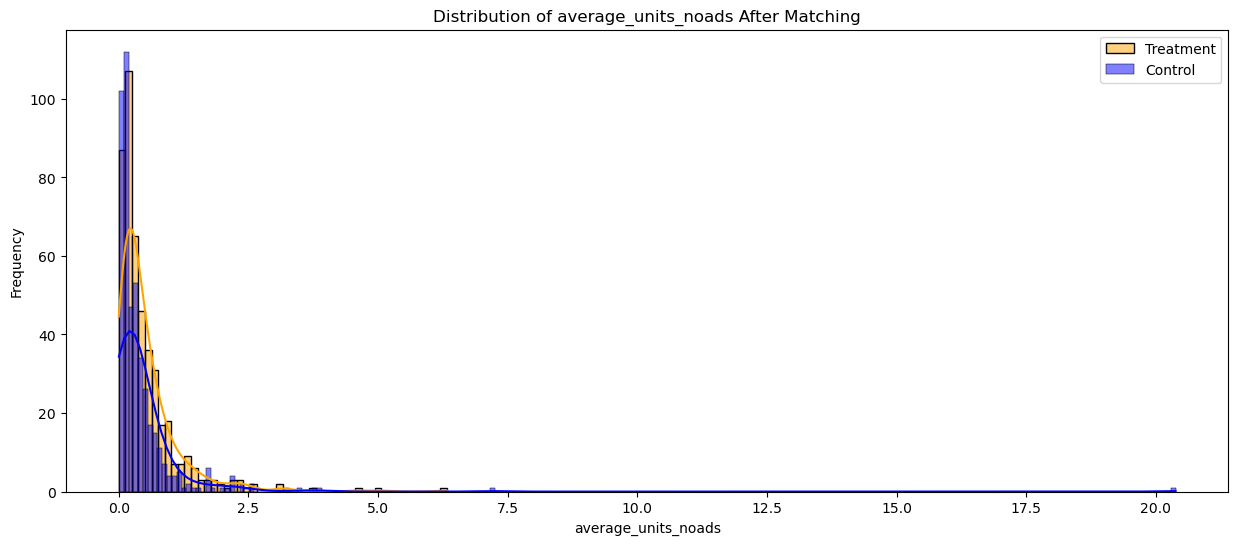

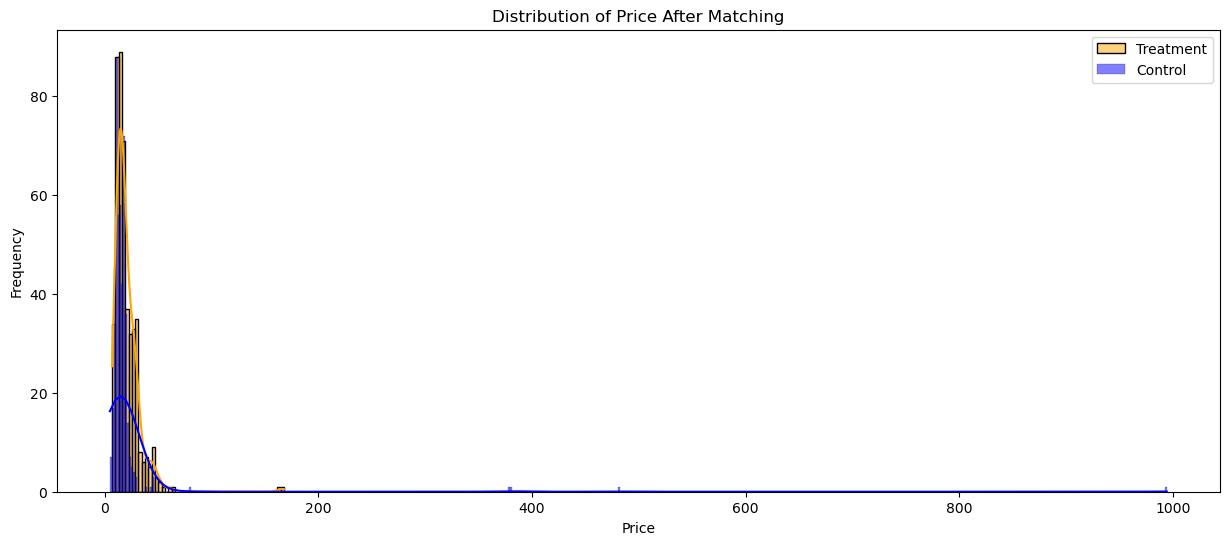

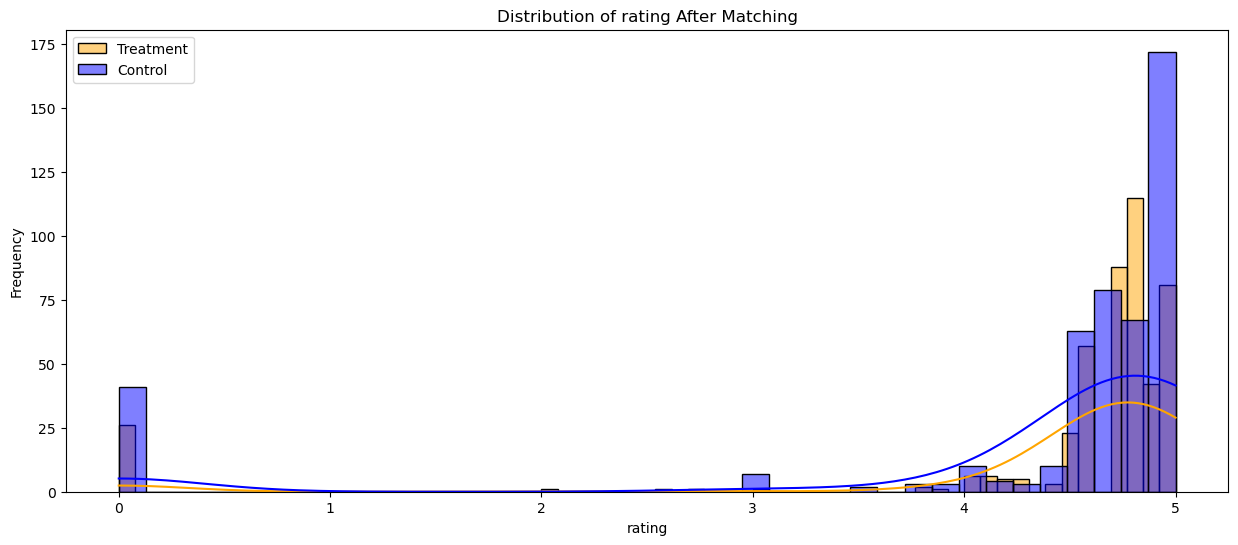

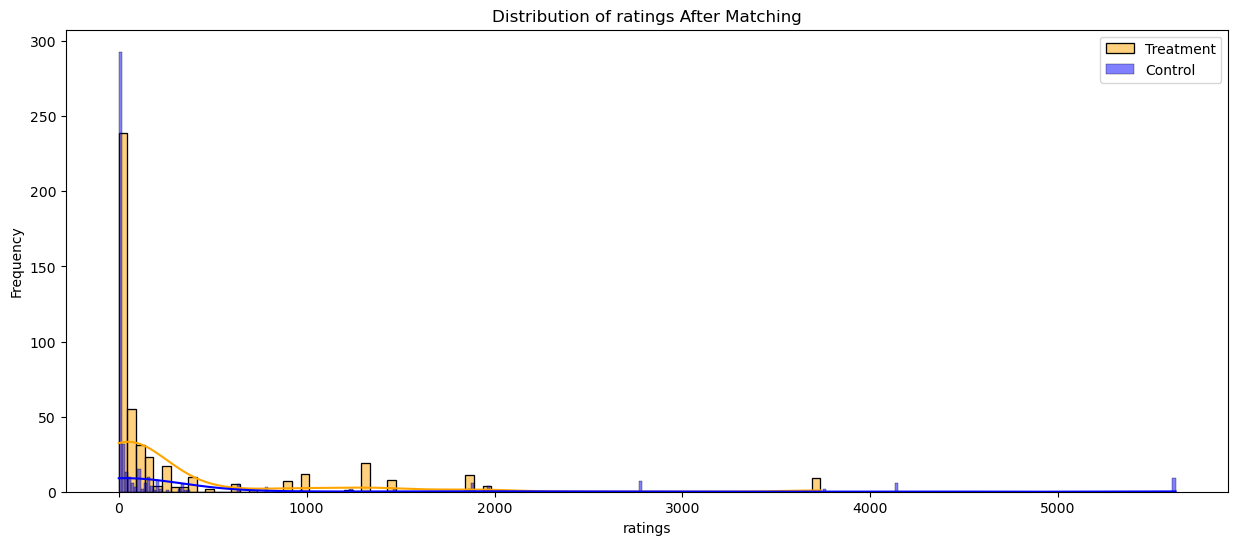

In [81]:
# Logistic
with open('matched_data_CSJ_lr.pkl', 'rb') as f:
    matched_data_CSJ_lr = pickle.load(f)
with open('best_model_CSJ_lr.pkl', 'rb') as f:
    best_model_CSJ_lr = pickle.load(f)
check_balance(matched_data_CSJ_lr, 'average_units_noads')
check_balance(matched_data_CSJ_lr, 'Price')
check_balance(matched_data_CSJ_lr, 'rating')
check_balance(matched_data_CSJ_lr, 'ratings')

##### Home & Kitchen

In [82]:
'''category = 'Home & Kitchen'
matched_data_HK_lr, best_model_HK_lr = get_matched_data(category)
best_model_HK_lr'''

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [83]:
'''with open('matched_data_HK_lr.pkl', 'wb') as f:
    pickle.dump(matched_data_HK_lr, f)
with open('best_model_HK_lr.pkl', 'wb') as f:
    pickle.dump(best_model_HK_lr, f) '''

T-Test Result - average_units_noads:
T-Statistic: -1.0354
P-Value: 0.3013
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: -2.3636
P-Value: 0.0187
The feature "Price" shows a significant difference after matching.

T-Test Result - rating:
T-Statistic: 1.9682
P-Value: 0.0499
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 0.0016
P-Value: 0.9987
The feature "ratings" shows no significant difference after matching.



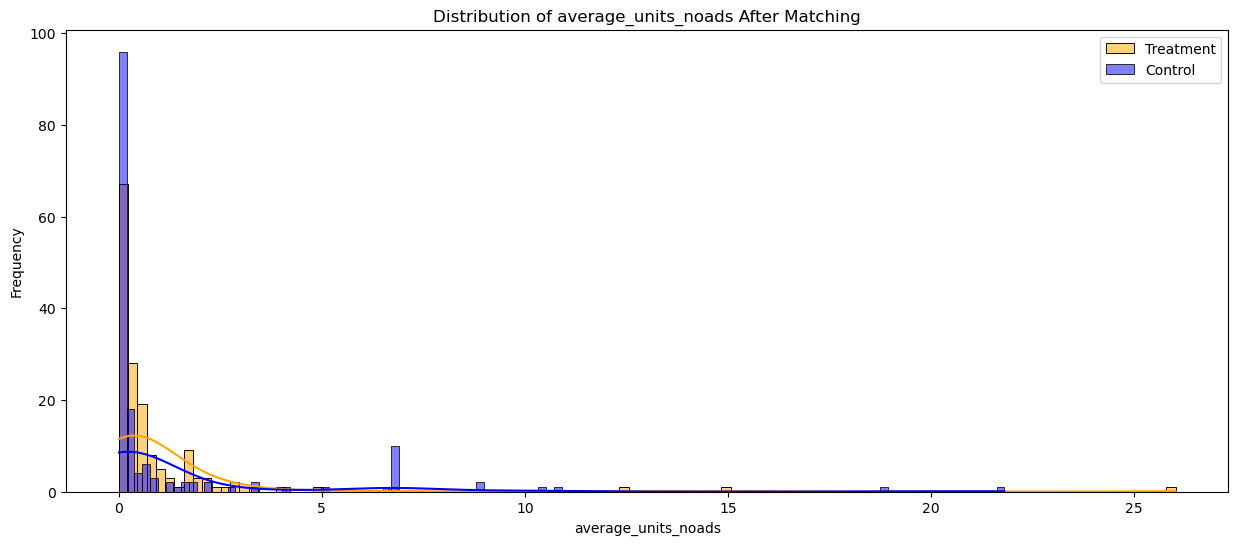

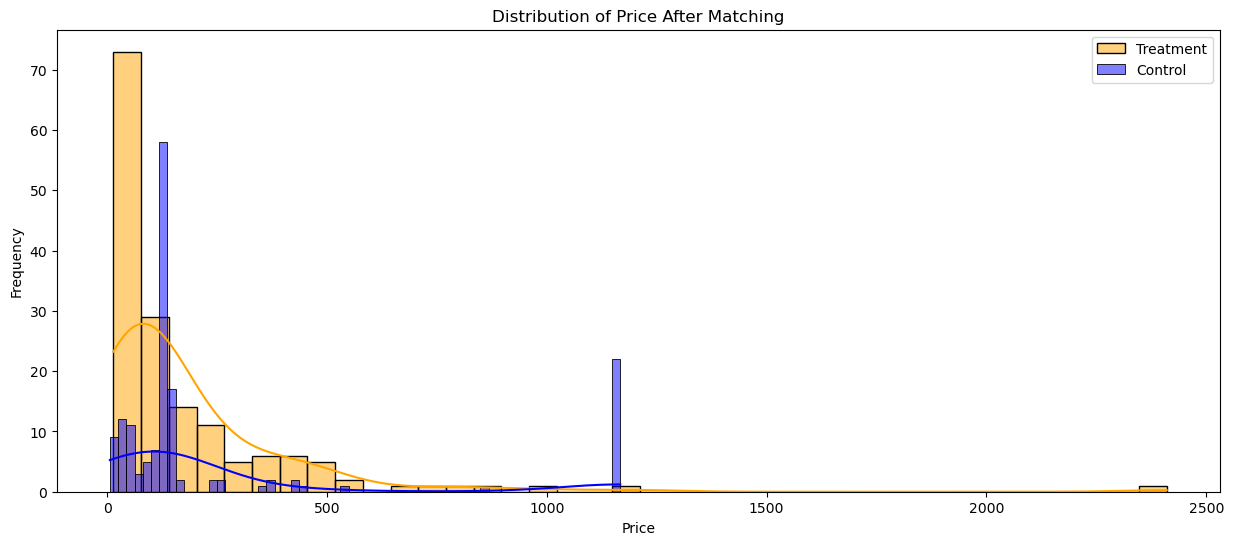

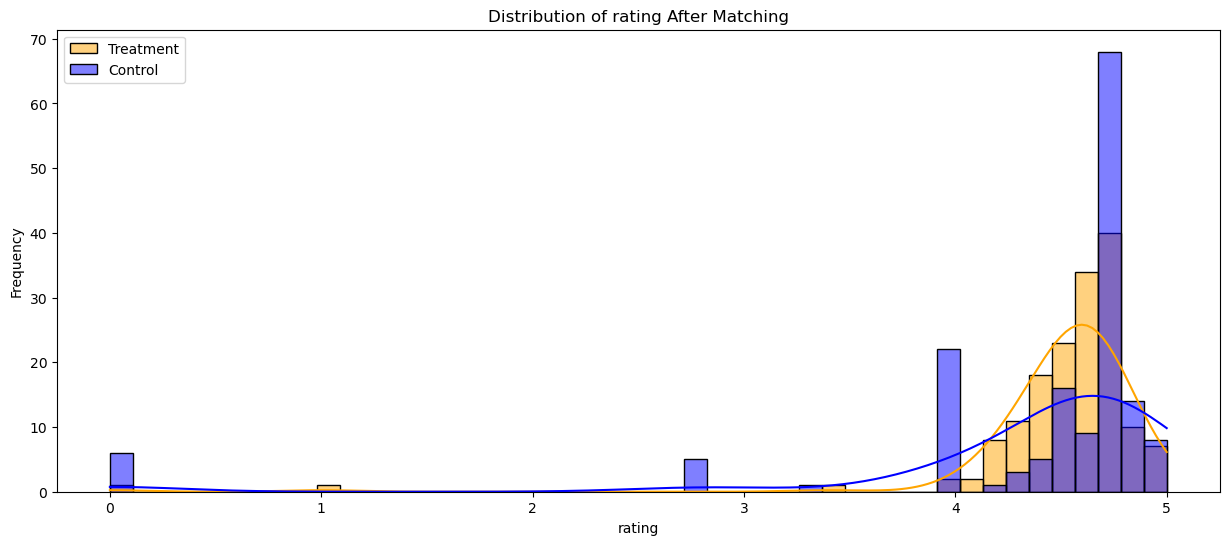

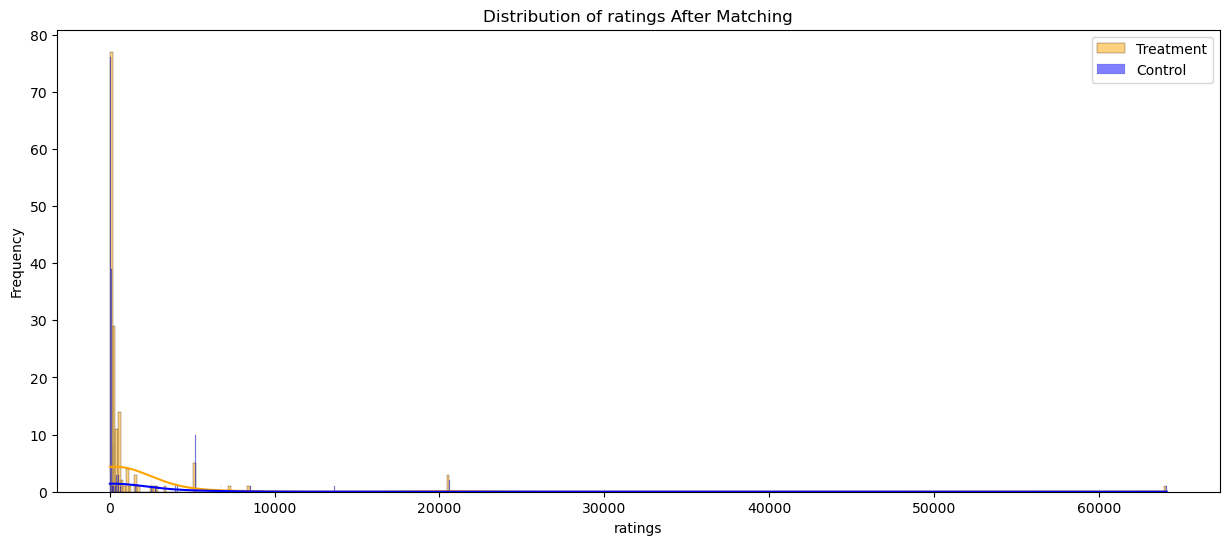

In [84]:
# Logistic
with open('matched_data_HK_lr.pkl', 'rb') as f:
    matched_data_HK_lr = pickle.load(f)
with open('best_model_HK_lr.pkl', 'rb') as f:
    best_model_HK_lr = pickle.load(f)
check_balance(matched_data_HK_lr, 'average_units_noads')
check_balance(matched_data_HK_lr, 'Price')
check_balance(matched_data_HK_lr, 'rating')
check_balance(matched_data_HK_lr, 'ratings')

### 3.4 Compare and Select

In [141]:
# Concatenate matched_data from different sources
Matched_Merge = pd.concat([matched_data_HH_lr[['treatment_asin', 'matched_asin']],
                          matched_data_CSJ_lr[['treatment_asin', 'matched_asin']],
                          matched_data_HK_lr[['treatment_asin', 'matched_asin']]])

# Merge Matched_Manual with Matched_Merge on 'treatment_asin'
Matched_Merge = pd.merge(Matched_Manual, Matched_Merge, on = 'treatment_asin', how = 'left', suffixes = ('_manual', '_model'))

# Fill NaN values in 'matched_asin_psm' with values from 'matched_asin_similarity'
Matched_Merge['matched_asin_model'].fillna(Matched_Merge['matched_asin_manual'], inplace = True)


In [142]:
Matched_Merge

,treatment_asin,matched_asin_manual,matched_asin_model
0,B00014TQ5A,B073YL2LTR,B073YL2LTR
1,B08HPKVJXG,B009NYU6M6,B0006M0A8E
2,B09CG7C8D4,B008M2T9GY,B09CCZYG8M
3,B09PC3TTK3,B09G8HYMQL,B08SQ3LK8L
4,B001683A34,B00CS4KGJ6,B0015SE750
...,...,...,...
2251,B07RZFGK87,B07GJKRK57,B07GJKRK57
2252,B08B73FRCY,B01ISF0MLA,B07CYJJ18N
2253,B09PC4ZVBJ,B08SQ3NC6D,B09PC372NR
2254,B0BJ41DWKF,B0016A940U,B0016BRT0G


### 3.5 Other Information

#### (i) Ads Sensitivity Analysis

In [109]:
# Merge Ads_Sensitivity with Treatment_Group to add category information
Ads_Sensitivity_Updated = pd.merge(Ads_Sensitivity, Treatment_Group[['first_category', 'second_category', 'last_category']], left_index = True, right_index = True)
# Merge Ads_Sensitivity_Updated with Ads to add brand_id information
Ads_Sensitivity_Updated = pd.merge(Ads_Sensitivity_Updated, Ads[['asin', 'brand_id']].drop_duplicates(), left_index = True, right_on = 'asin')

Ads_Sensitivity_Updated = Ads_Sensitivity_Updated.set_index('asin')
Ads_Sensitivity_Updated.sort_values(by = 'sensitivity', ascending = False).head(30)

,sensitivity,first_category,second_category,last_category,brand_id
asin,,,,,
B00XBZFWJA,2724.944444,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B004O2I1Z6,235.428016,Beauty & Personal Care,Skin Care,Creams,44
B07V2BTRY1,205.637931,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B00OA6NLG0,184.523288,Health & Household,"Vitamins, Minerals & Supplements",Acetyl-L-Carnitine,3
B07VKPJTRG,126.586207,"Clothing, Shoes & Jewelry",Men,Socks,353
B09G8JWQJ4,120.552941,"Clothing, Shoes & Jewelry",Men,Active,353
B00N9E4J3I,97.181818,"Clothing, Shoes & Jewelry",Luggage & Travel Gear,Travel Duffels,356
B00V6MUCL8,94.014451,Health & Household,"Vitamins, Minerals & Supplements",Magnesium,12
B000FGZG3A,92.687223,Health & Household,Diet & Sports Nutrition,Detox & Cleanse,5


In [112]:
Ads_Sensitivity_Updated

,sensitivity,first_category,second_category,last_category,brand_id
asin,,,,,
B0000225HZ,6.326747,Tools & Home Improvement,Power & Hand Tools,Battery Packs,58
B0000225IB,1.411714,Tools & Home Improvement,Power & Hand Tools,Framing Nailers,58
B00006RGKR,12.295938,Industrial & Scientific,Fasteners,Brad Nails,58
B0000A1WGL,0.761874,Home & Kitchen,Furniture,DVD Cases,356
B0000AQO13,-0.725191,Home & Kitchen,Kitchen & Dining,Griddles,458
...,...,...,...,...,...
B0BLTBJQMX,0.840000,"Clothing, Shoes & Jewelry",Novelty & More,Socks,353
B0BLTCK4B7,2.068027,"Clothing, Shoes & Jewelry",Men,Athletic Socks,353
B0BLZVC6W3,-0.019608,"Patio, Lawn & Garden",Grills & Outdoor Cooking,Smoker Chips,458


In [114]:
Ads_Sensitivity_Updated.describe()
# sensitivity 25%:0.122 --> log:-2.1
# sensitivity 75%:2.067 --> log:0.73

,sensitivity,brand_id
count,2234.000000,2256.000000
mean,4.059534,227.388298
std,58.671434,174.904005
min,-1.000000,2.000000
25%,0.122006,12.000000
50%,0.658344,334.000000
75%,2.067467,356.000000
max,2724.944444,518.000000


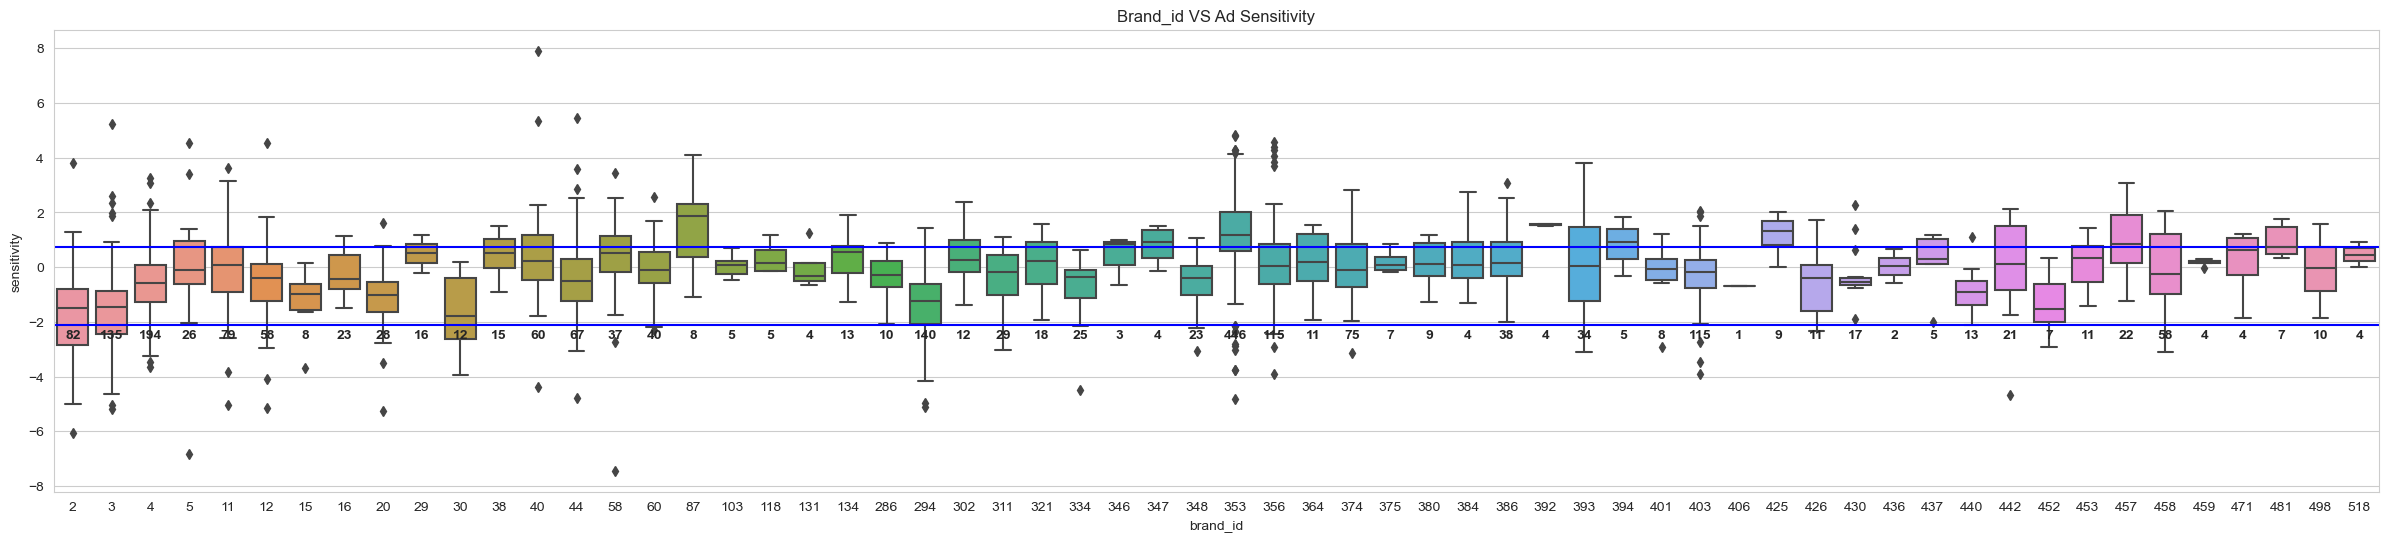

In [118]:
plt.figure(figsize = (30, 6))
# Create a boxplot to visualize the relationship between 'brand_id' and log-transformed 'sensitivity'
sns.boxplot(x = 'brand_id', y = np.log(Ads_Sensitivity_Updated.sensitivity), data = Ads_Sensitivity_Updated)
plt.title('Brand_id VS Ad Sensitivity')
sns.set_style('whitegrid')
# Add the count of each 'brand_id' on the plot
for i, count in enumerate(Ads_Sensitivity_Updated.brand_id.value_counts().sort_index()):
    plt.text(i, -2.5, f'{count}', ha = 'center', va = 'center', fontweight = 'bold')
plt.axhline(y = 0.73, linestyle = '-', color = 'b')
plt.axhline(y = -2.1, linestyle = '-', color = 'b')
plt.show()

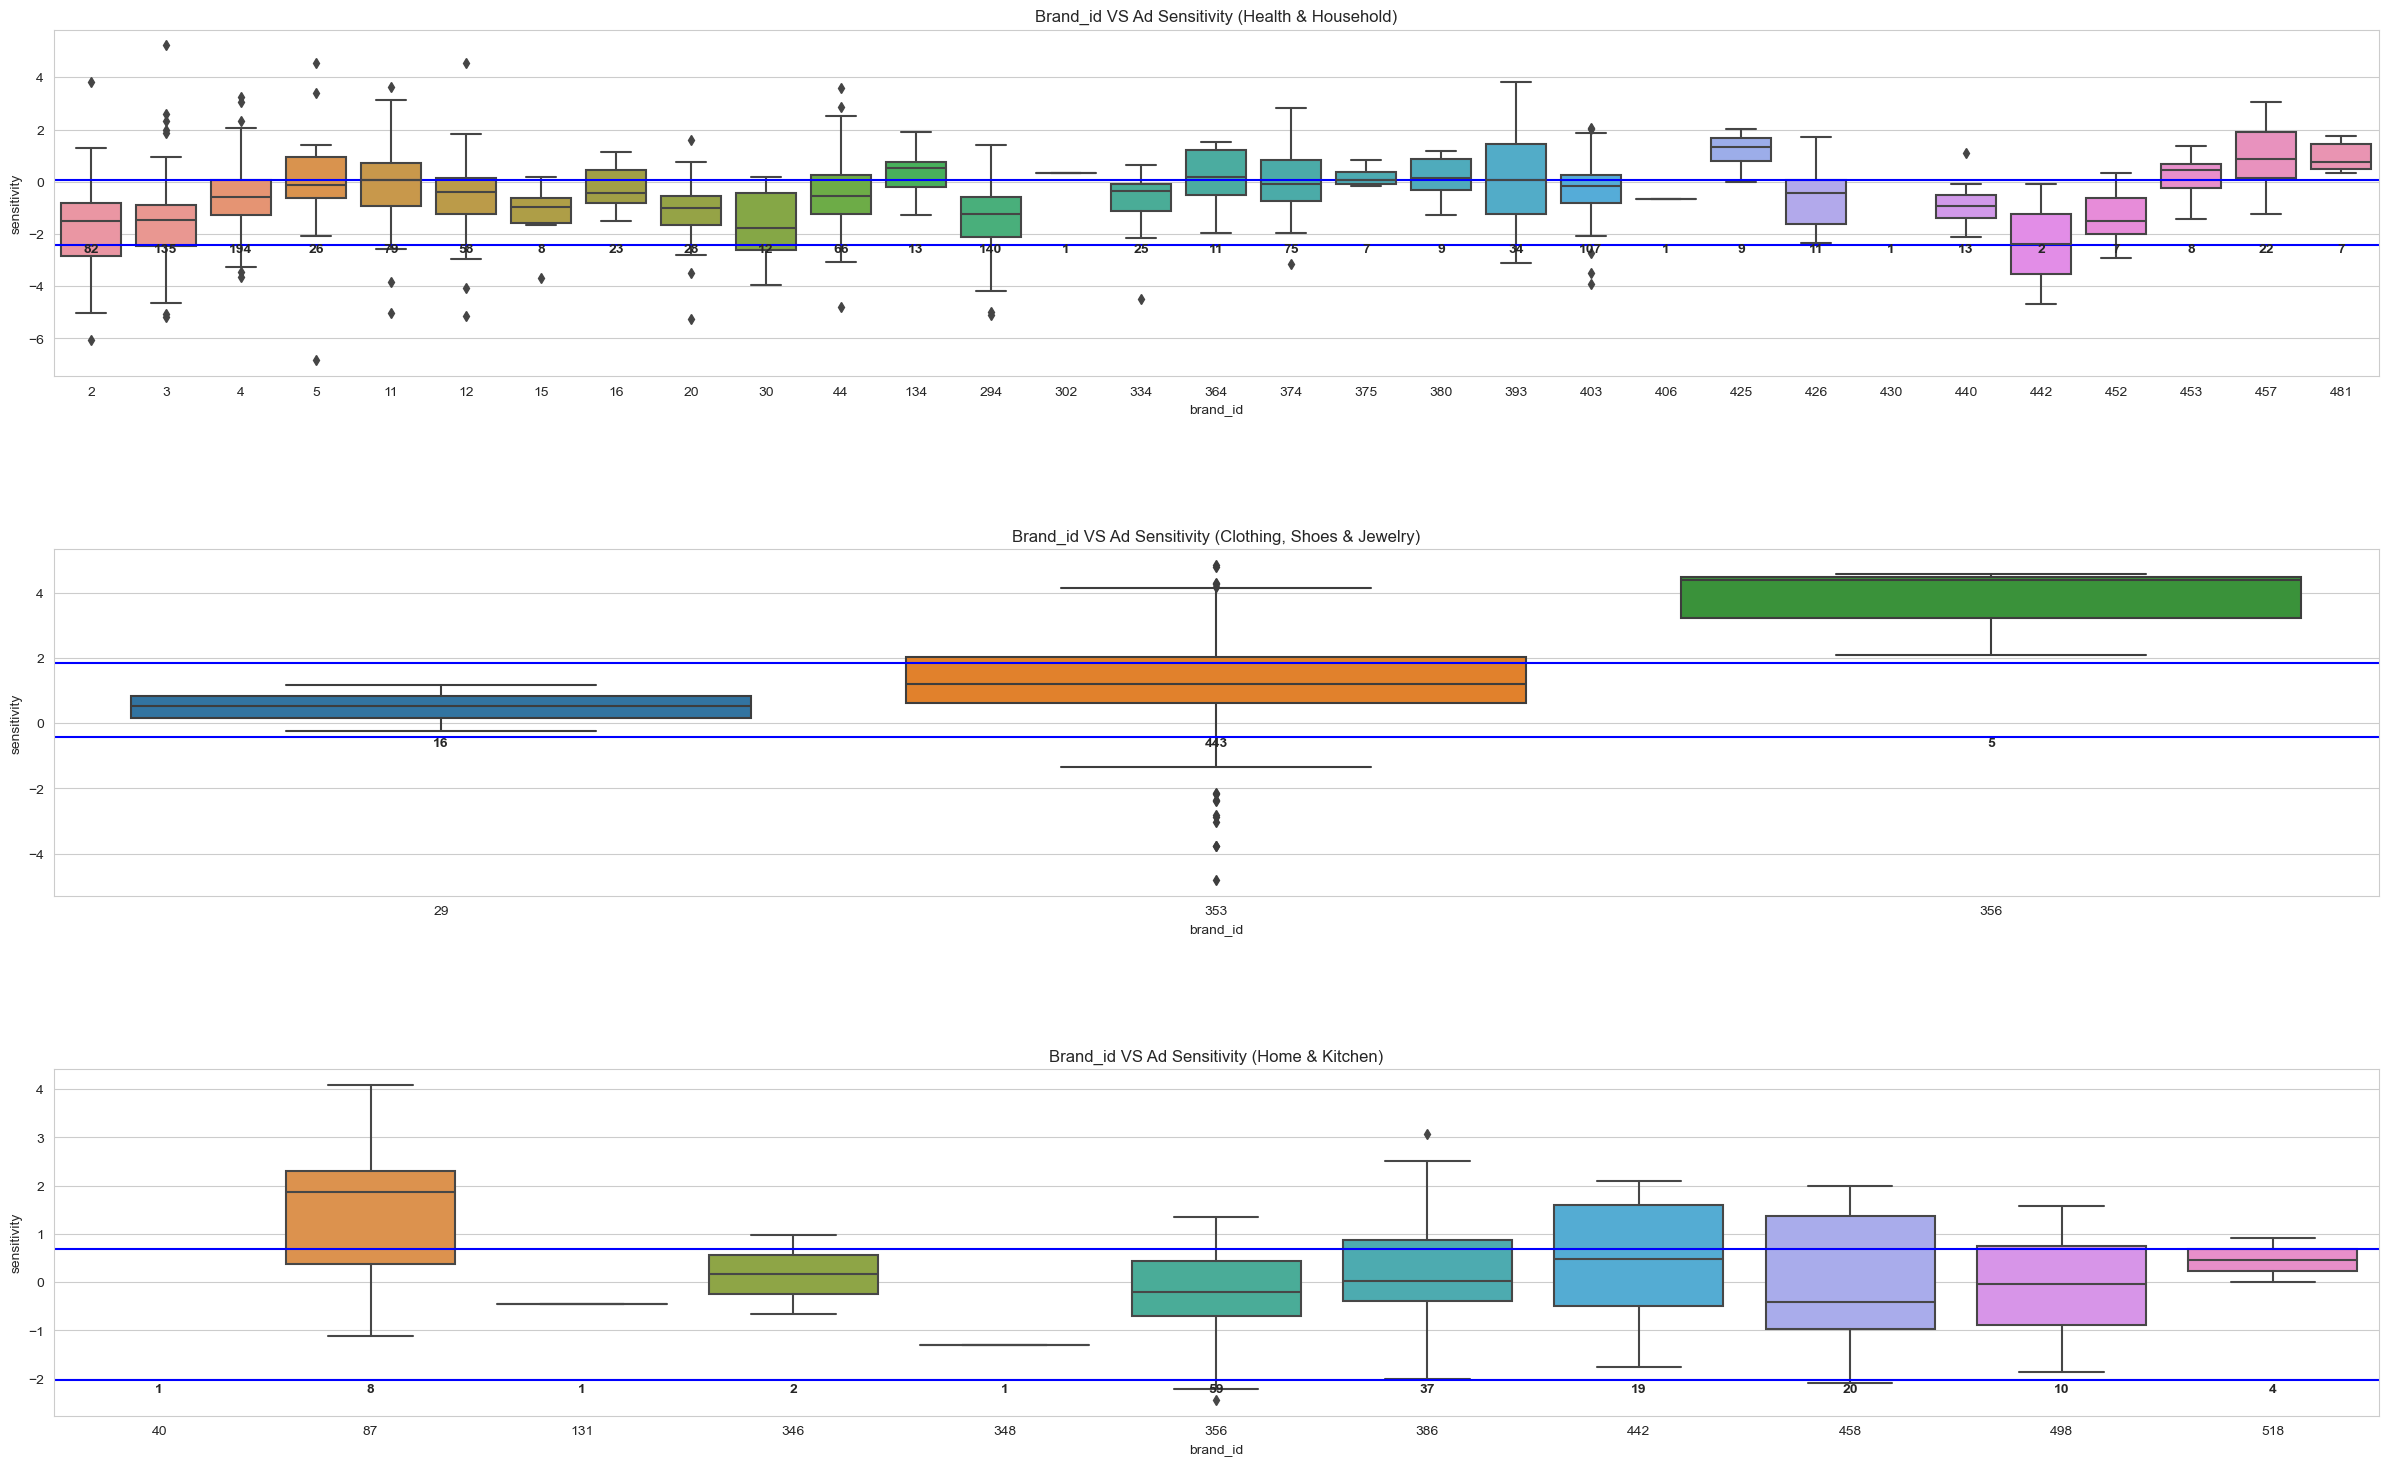

In [128]:
plt.figure(figsize = (30, 18))

# First subplot: Health & Household
plt.subplot(3, 1, 1)
HH_data = Ads_Sensitivity_Updated[Ads_Sensitivity_Updated['first_category'] == 'Health & Household']
y_min = np.log(HH_data.sensitivity.quantile(0.25))
y_max = np.log(HH_data.sensitivity.quantile(0.75))
sns.boxplot(x = 'brand_id', y = np.log(HH_data.sensitivity), data = HH_data)
plt.title('Brand_id VS Ad Sensitivity (Health & Household)')
sns.set_style('whitegrid')
for i, count in enumerate(HH_data.brand_id.value_counts().sort_index()):
    plt.text(i, y_min - 0.2, f'{count}', ha = 'center', va = 'center', fontweight = 'bold')
plt.axhline(y = y_max, linestyle='-', color = 'b')
plt.axhline(y = y_min, linestyle='-', color = 'b')

# Second subplot: Clothing, Shoes & Jewelry
plt.subplot(3, 1, 2)
CSJ_data = Ads_Sensitivity_Updated[Ads_Sensitivity_Updated['first_category'] == 'Clothing, Shoes & Jewelry']
y_min = np.log(CSJ_data.sensitivity.quantile(0.25))
y_max = np.log(CSJ_data.sensitivity.quantile(0.75))
sns.boxplot(x = 'brand_id', y = np.log(CSJ_data.sensitivity), data = CSJ_data)
plt.title('Brand_id VS Ad Sensitivity (Clothing, Shoes & Jewelry)')
sns.set_style('whitegrid')
for i, count in enumerate(CSJ_data.brand_id.value_counts().sort_index()):
    plt.text(i, y_min - 0.2, f'{count}', ha = 'center', va = 'center', fontweight = 'bold')
plt.axhline(y = y_max, linestyle='-', color = 'b')
plt.axhline(y = y_min, linestyle='-', color = 'b')

# Third subplot: Home & Kitchen
plt.subplot(3, 1, 3)
HK_data = Ads_Sensitivity_Updated[Ads_Sensitivity_Updated['first_category'] == 'Home & Kitchen']
y_min = np.log(HK_data.sensitivity.quantile(0.25))
y_max = np.log(HK_data.sensitivity.quantile(0.75))
sns.boxplot(x = 'brand_id', y = np.log(HK_data.sensitivity), data = HK_data)
plt.title('Brand_id VS Ad Sensitivity (Home & Kitchen)')
sns.set_style('whitegrid')
for i, count in enumerate(HK_data.brand_id.value_counts().sort_index()):
    plt.text(i, y_min - 0.2, f'{count}', ha = 'center', va = 'center', fontweight = 'bold')
plt.axhline(y = y_max, linestyle='-', color = 'b')
plt.axhline(y = y_min, linestyle='-', color = 'b')

plt.subplots_adjust(hspace = 0.5)
plt.show()


**Note**  
By visualizing the 'ads_sensitivity' according to 'category' and 'brand', we can compare the distribution of advertising sensitivity across different brands. We can focus on those brands with significantly higher or lower ad sensitivity and attempt to identify factors that may influence ad sensitivity. For instance, among the three brands listed under 'Clothing, Shoes & Jewelry' (CSJ), brand 356 exhibits higher sensitivity than 353 and 29. This could indicate that brand 356's marketing strategies, customer base, or product offerings are more responsive to advertising. It would be valuable to investigate these aspects further and determine what specific factors contribute to this higher advertising sensitivity.

#### (ii) Indentify Outliers
- The ads effect of these products are significantly greater than effect of other products.

In [110]:
threshold = 3
temp = Ads_Sensitivity_Updated[~Ads_Sensitivity_Updated['sensitivity'].isin([-1])].dropna()
temp = temp.reset_index()
outliers = temp.groupby(['first_category', 'second_category', 'last_category']).apply(lambda x: x[abs(stats.zscore(x['sensitivity'])) > threshold].sort_values(by='sensitivity', ascending=False)).reset_index(drop = True)
outliers.set_index(['first_category', 'second_category', 'last_category'])

asin  \
first_category            second_category                  last_category                                       
Clothing, Shoes & Jewelry Men                              Athletic Socks                         B07VM9W3TK   
                                                           Athletic Socks                         B08H53C9XD   
                                                           Athletic Socks                         B08R2MRGBL   
                                                           Athletic Socks                         B09G8HPVFX   
                                                           Athletic Socks                         B09PC3C2TQ   
                                                           Boxer Briefs                           B09PC4R4D4   
                                                           Liners & Ankle Socks                   B09G8KVV4S   
                                                           Socks                                  B07VKPJTRG   
                          Novelty & More                   Socks                                  B076Z87LZR   
                          Westlake                         Westlake                               B08ZT14873   
                          Women                            Athletic Socks                         B09L54NW12   
                                                           Socks                                  B09L532SDT   
Health & Household        Diet & Sports Nutrition          Detox & Cleanse                        B000FGZG3A   
                          Vitamins, Minerals & Supplements Adrenal Extracts                       B00J8CEPXE   
                                                           B-Complex                              B000KYSCOM   
                                                           Blended Vitamin & Mineral Supplements  B08HSLQQPD   
                                                           Blended Vitamin & Mineral Supplements  B09BZSVGLV   
                                                           Blended Vitamin & Mineral Supplements  B000Z8BB4Q   
                                                           Blended Vitamin & Mineral Supplements  B009LI7VRC   
                                                           Blended Vitamin & Mineral Supplements  B003PR3OVW   
                                                           CoQ10                                  B01M6A97R0   
                                                           Magnesium                              B00V6MUCL8   
                                                           Milk Thistle                           B000Z597EA   
                                                           Multi-Enzymes                          B005HXOBFA   
                                                           Multivitamins                          B0929TCDDW   
                                                           Probiotics                             B012E7IV52   
                                                           Turmeric                               B006P8NAHQ   
                                                           Vitamin C                              B0010ED38G   
                                                           Vitamin C                              B000MDY7RC   
                                                           Vitamin D                              B00EPQN6TW   
Home & Kitchen            Kitchen & Dining                 Countertop Blenders                    B00GPRPWAU   
Industrial & Scientific   Fasteners                        Framing Nails                          B002NU6HDY   
Sports & Outdoors         Outdoor Recreation               Camping Stoves                         B007PK9RG6   
Tools & Home Improvement  Building Supplies                Ventilation Fans                       B00XBZFWJA   

                                                                       

## 4 Demo
- If the input ASIN belongs to a category for which there is no pre-trained model available, the process will only consider the control product matched manually.

In [190]:
asin_treat = None
asin_control = None

def analyze_data(asin_input, data=Matched_Merge):
    """
    Analyze the data for a given ASIN.

    Args:
        asin_input (str): ASIN to analyze.
        data (DataFrame): DataFrame containing matched product information.

    """
    global asin_control
    asin_treat = asin_input

    try:
        category = Treatment_Group.loc[asin_input, 'first_category']
    except KeyError:
        print('No matching record found for the given ASIN.')
        return

    try:
        if category not in ['Health & Household', 'Clothing, Shoes & Jewelry', 'Home & Kitchen']:
            print(f"Category {category} has not been pre-trained.")
            pass

        try:
            asin_control_model = data[data['treatment_asin'] == asin_treat]['matched_asin_model'].values[0]
            asin_control_manual = data[data['treatment_asin'] == asin_treat]['matched_asin_manual'].values[0]
        except IndexError:
            print('No matching record found for the given ASIN.')
            return

        plot_total_units(asin_treat, asin_control_model, asin_control_manual)
        asin_control, result = calculate_cointegration(asin_treat, data)
        print('First Category of ASIN input:', category)
        print('Best matching ASIN:', asin_control)
        print('Cointegration statistic:', result[0])
        print('p-value:', result[1])
    except Exception as e:
        print('An error occurred:', str(e))



asin_input = widgets.Text(description='ASIN:')


def analyze_button_clicked(button):
    global asin_treat
    asin_value = asin_input.value
    asin_treat = asin_value

    try:
        analyze_data(asin_value)
        DID_analyze(asin_value, asin_control)
    except Exception as e:
        print('An error occurred:', str(e))


analyze_button = widgets.Button(description='Analyze')
analyze_button.on_click(analyze_button_clicked)

display(asin_input, analyze_button)

Text(value='', description='ASIN:')

Button(description='Analyze', style=ButtonStyle())

In [180]:
# Robustness Test
get_segments(Ads_Agg, asin_treat)

,Start,End,Segment Type,Duration,Sales
0,2022-01-02,2022-08-10,no ads,221.0,297.0
1,2022-08-11,2022-08-12,ads,2.0,11.0
2,2022-08-13,2022-08-14,no ads,2.0,4.0
3,2022-08-15,2022-08-15,ads,1.0,2.0
4,2022-08-16,2022-08-26,no ads,11.0,7.0
5,2022-08-27,2022-08-28,ads,2.0,3.0
6,2022-08-29,2022-09-05,no ads,8.0,4.0
7,2022-09-06,2022-09-13,ads,8.0,35.0
8,2022-09-14,2022-09-14,no ads,1.0,6.0
9,2022-09-15,2022-11-13,ads,60.0,410.0


In [189]:
robustness_test(asin_treat, asin_control, '2022-11-16', 7)

asin_treat: B08DL3S2D6
asin_control: B09G8C7JKH


The assumption of normality is violated.
Wilcoxon Signed-Rank Test:
There is a statistically significant difference between the two paired samples.
(0.03125, 1.0)


Paired sample t-test:
No statistically significant difference is observed.
(nan, nan)
